# charts.ipynb

This notebook generates figures that track the fluctuation in HbA1c measures during the COVID-19 pandemic, focusing on those with T2DM and elevated HbA1c or prediabetes prepandemic.

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from datetime import datetime
from functools import reduce
from glob import glob

pd.options.mode.chained_assignment = None

In [2]:
fpath = "../output/data"

In [3]:
# Create total dataframes
df_all_dm = pd.read_csv(f"{fpath}/measure_total_tests_by_dm.csv", index_col=0)
df_gt48_dm = pd.read_csv(f"{fpath}/measure_tests_gt48_by_dm.csv", index_col=0).drop(columns=['population'])
df_gt58_dm = pd.read_csv(f"{fpath}/measure_tests_gt58_by_dm.csv", index_col=0).drop(columns=['population'])
df_gt64_dm = pd.read_csv(f"{fpath}/measure_tests_gt64_by_dm.csv", index_col=0).drop(columns=['population'])
df_gt75_dm = pd.read_csv(f"{fpath}/measure_tests_gt75_by_dm.csv", index_col=0).drop(columns=['population'])

In [4]:
# Compute per 1,000 counts
def create_per_1000(df_in, var_rename):
    df_in['value'] = df_in['value']*1000
    df_in = df_in.rename(columns={'value':var_rename})
    return df_in

df_all_dm = create_per_1000(df_all_dm, 'tests_per_1000')
df_gt48_dm = create_per_1000(df_gt48_dm, 'gt48_per_1000')
df_gt58_dm = create_per_1000(df_gt58_dm, 'gt58_per_1000')
df_gt64_dm = create_per_1000(df_gt64_dm, 'gt64_per_1000')
df_gt75_dm = create_per_1000(df_gt75_dm, 'gt75_per_1000')

base_dfs = [df_all_dm, df_gt48_dm, df_gt58_dm, df_gt64_dm, df_gt75_dm]

In [5]:
df_total = reduce(lambda left,right: pd.merge(left,right,on=['diabetes_type','date']), base_dfs)
df_total['date'] = df_total['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d'))
df_total_nodm = df_total.loc[df_total.diabetes_type == 'NO_DM']
df_total_t1dm = df_total.loc[df_total.diabetes_type == 'T1DM']
df_total_t2dm = df_total.loc[df_total.diabetes_type == 'T2DM']

In [6]:
# Create percentage of tests by threshold    
def create_pct(df_in, var):
    df_in[var + '_pct'] = (df_in[var]/df_in['took_hba1c'])*100
    
thresholds = ['hba1c_gt_48', 'hba1c_gt_58', 'hba1c_gt_64', 'hba1c_gt_75']
for t in thresholds:
    create_pct(df_total_nodm, t)
    create_pct(df_total_t1dm, t)
    create_pct(df_total_t2dm, t)

In [7]:
# Dictionary to recode variables
dict_eth = {1: 'White', 2: 'Mixed', 3: 'Asian',
            4: 'Black', 5: 'Other', np.nan: 'Unknown',
            0: 'Unknown'}

dict_imd = {0: 'Unknown', 1: '1 Most deprived', 2: '2',
            3: '3', 4: '4', 5: '5 Least deprived'}

dict_ld = {1:'Yes', 0:'No'}

# Create lists of dataframes broken down by demographics
def create_subdf(th):
    demos = ['age', 'sex', 'ethnicity', 'region', 'imd', 'ld', 'mi']
    li_df = []
    li_df_t1dm = []
    li_df_t2dm = []
    for d in demos:
        df_all = pd.read_csv(f"{fpath}/measure_{th}_by_dm_and_{d}.csv", index_col=0)
        df_all['tests_per_1000'] = df_all['value']*1000
        df_all['date'] = df_all['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d'))
        
        if d == 'age':
            df_all = df_all.loc[df_all.age_group != '0-15']
        
        if d == 'ethnicity':
            # Format ethnicity
            df_all = df_all.replace({"ethnicity": dict_eth})
            
        if d == 'imd':
            # Format IMD 
            df_all = df_all.replace({'imd': dict_imd})
        
        if d == 'ld':
            # Format learning disability label
            df_all = df_all.replace({'learning_disability': dict_ld})
        
        df_nodm = df_all.loc[df_all.diabetes_type == 'NO_DM']
        df_t1dm = df_all.loc[df_all.diabetes_type == 'T1DM']
        df_t2dm = df_all.loc[df_all.diabetes_type == 'T2DM']
        li_df.append(df_nodm)
        li_df_t1dm.append(df_t1dm)
        li_df_t2dm.append(df_t2dm)
   
    return li_df, li_df_t1dm, li_df_t2dm

li_df, li_df_t1dm, li_df_t2dm = create_subdf('total_tests')
li_df_gt48, li_df_t1dm_gt48, li_df_t2dm_gt48 = create_subdf('tests_gt48')
li_df_gt58, li_df_t1dm_gt58, li_df_t2dm_gt58 = create_subdf('tests_gt58')
li_df_gt64, li_df_t1dm_gt64, li_df_t2dm_gt64 = create_subdf('tests_gt64')
li_df_gt75, li_df_t1dm_gt75, li_df_t2dm_gt75 = create_subdf('tests_gt75')

In [8]:
# Concatenate thresholds by demographics for patients with T2DM
drop_col = ['population','value','tests_per_1000']
demo_vars = ['age_group', 'sex', 'ethnicity', 'region', 'imd', 'learning_disability', 'mental_illness']

df_thresholds = []
for i in range(0,len(li_df)):
    dfs = []
    dfs.append(li_df_t2dm[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt48[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt58[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt64[i].drop(columns=drop_col))
    dfs.append(li_df_t2dm_gt75[i].drop(columns=drop_col))
    df_concat = reduce(lambda left,right: pd.merge(left,right,on=['diabetes_type','date',demo_vars[i]]), dfs)
    for t in thresholds:
        create_pct(df_concat, t)
    df_thresholds.append(df_concat)

In [9]:
# Functions to generate charts
def create_chart(title, df, measures, ax):
    sns.lineplot(x='date', y='value', hue='variable', ax=ax, ci=None,
                 data=pd.melt(df[['date'] + measures], ['date']))
    
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of HbA1c Tests per 1,000')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])
    
def create_subplot(measure, group, title, df, ax):
    # Create the scatter plot
    sns.lineplot(x='date', y=measure,
                 hue=group, data=df, ax=ax)
    # Set title and make axes labels empty
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of HbA1c Tests per 1,000')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[1:], labels=labels[1:])

def create_plotgrid(measure, dfs, ylabel, filename, title):
    fig2, axes2 = plt.subplots(4, 2, figsize=(16,24), sharex=True, sharey=True)
    fig2.delaxes(ax=axes2[3,1])

    create_subplot(measure, 'age_group', 'Age Group', 
                   dfs[0].loc[dfs[0].age_group != 'missing'], axes2[0,0])
    create_subplot(measure, 'sex', 'Sex', 
                   dfs[1].loc[dfs[1].sex.isin(['F','M'])], axes2[0,1])
    create_subplot(measure, 'ethnicity', 'Ethnicity', 
                   dfs[2], axes2[1,0])
    create_subplot(measure, 'region', 'Region', 
                   dfs[3], axes2[1,1])
    create_subplot(measure, 'imd', 'IMD', 
                   dfs[4], axes2[2,0])
    create_subplot(measure, 'learning_disability', 'Learning Disability', 
                   dfs[5], axes2[2,1])
    create_subplot(measure, 'mental_illness', 'Mental Illness', 
                   dfs[6], axes2[3,0])

    # Set axes labels
    plt.setp(axes2[-1, :],
             xlabel='Date')
    plt.setp(axes2[:, 0],
             ylabel=ylabel)
    fig2.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig2.suptitle(title, fontsize=16)
    plt.savefig('../output/' + filename + '.png')
    plt.show()

_______

## Total Number

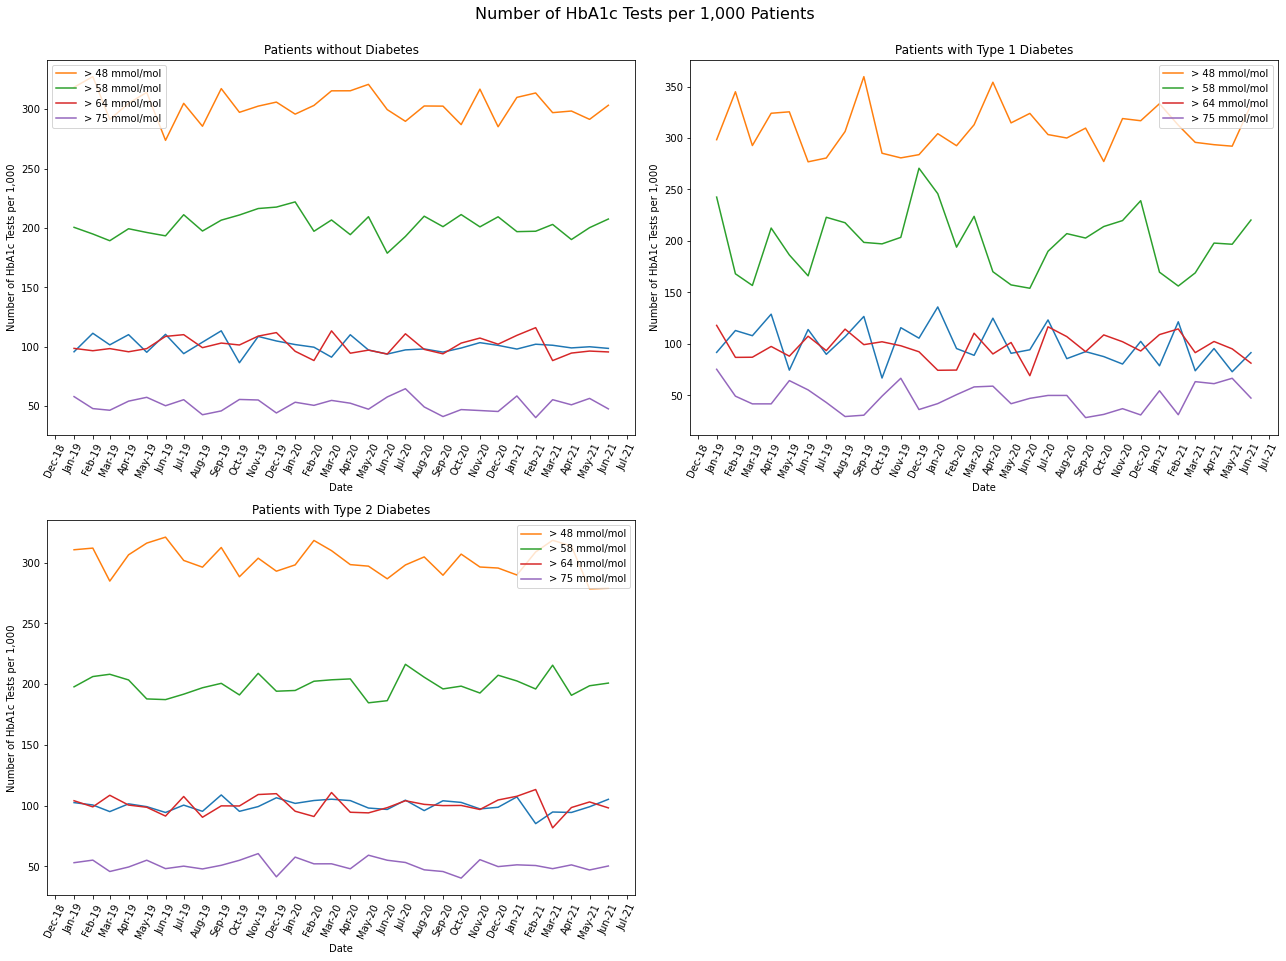

In [10]:
dict_col_rename = {'tests_per_1000':'Total','gt48_per_1000':'> 48 mmol/mol',
                   'gt58_per_1000':'> 58 mmol/mol','gt64_per_1000':'> 64 mmol/mol',
                   'gt75_per_1000':'> 75 mmol/mol'}

plt_cols = ['Total','> 48 mmol/mol','> 58 mmol/mol','> 64 mmol/mol','> 75 mmol/mol']

# Total number
fig, axes = plt.subplots(2,2, figsize=(18, 14))
fig.delaxes(ax=axes[1,1])
create_chart('Patients without Diabetes', df_total.rename(columns=dict_col_rename), 
             plt_cols, axes[0,0])
create_chart('Patients with Type 1 Diabetes', df_total_t1dm.rename(columns=dict_col_rename),
             plt_cols, axes[0,1])
create_chart('Patients with Type 2 Diabetes', df_total_t2dm.rename(columns=dict_col_rename),
             plt_cols,axes[1,0])

fig.suptitle('Number of HbA1c Tests per 1,000 Patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('../output/total_by_dm.png')
plt.show()

### By Demographics

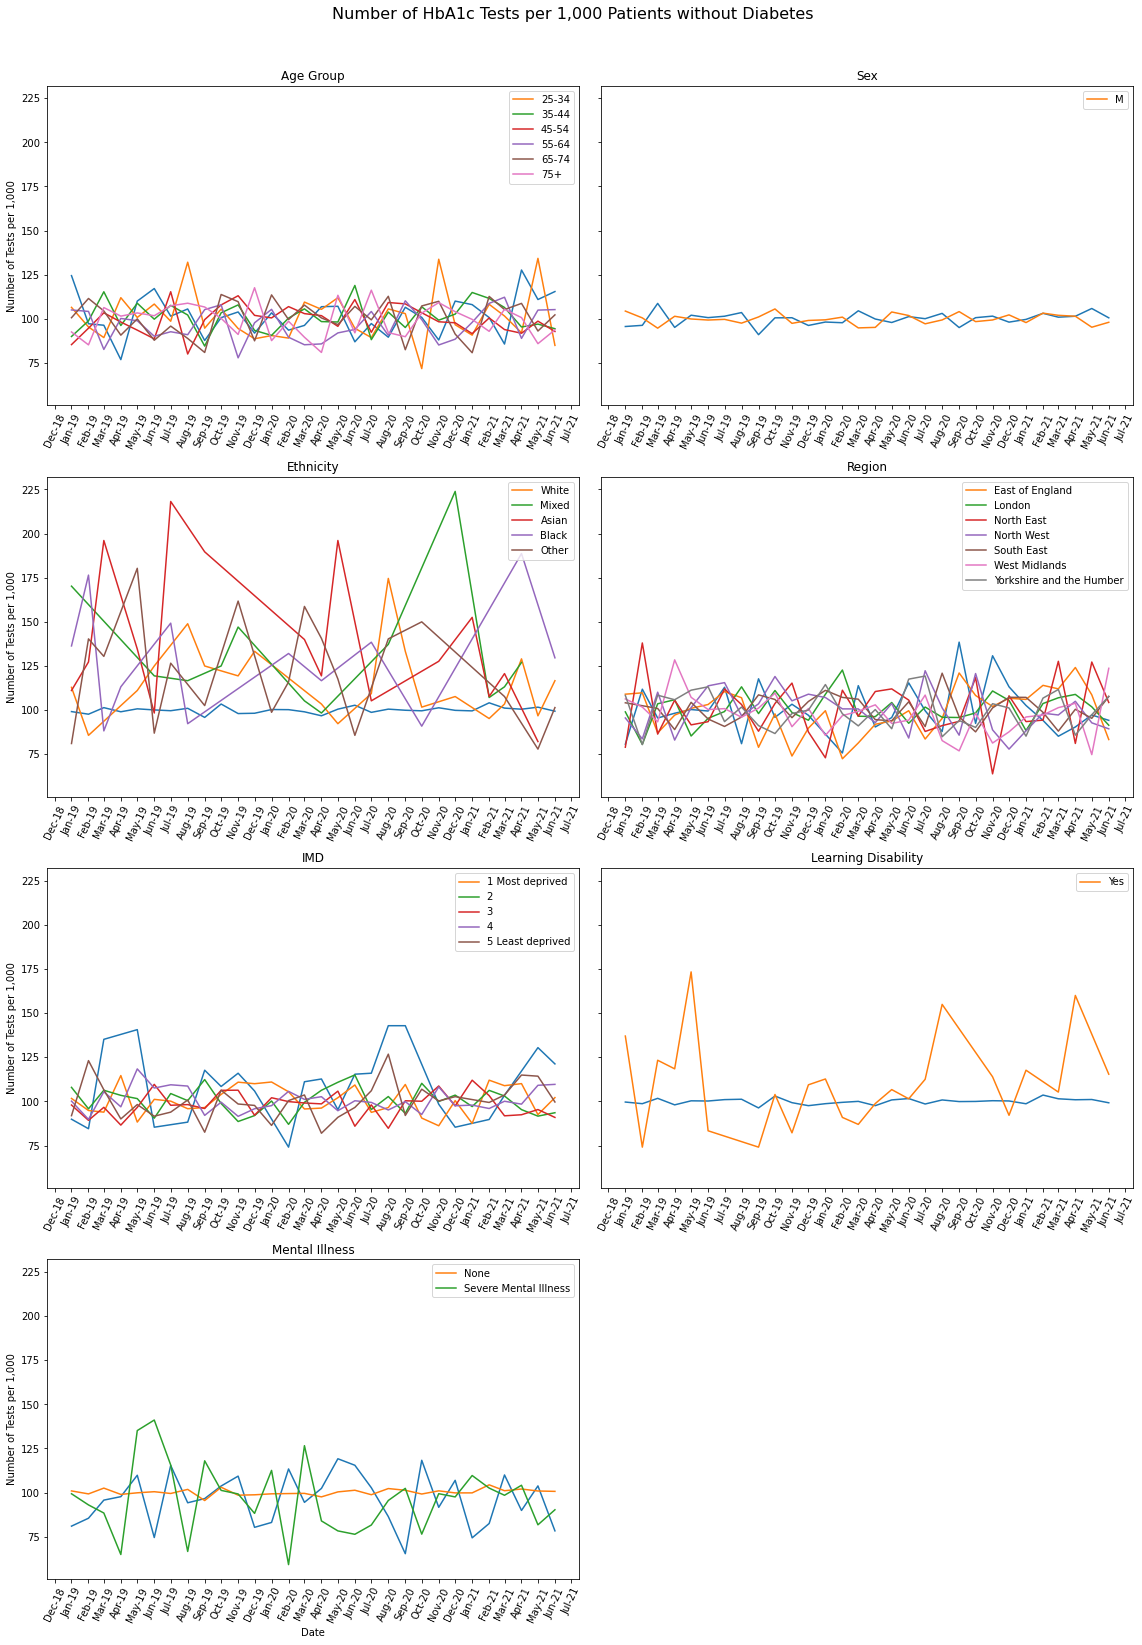

In [11]:
# Patients without diabetes
create_plotgrid('tests_per_1000', li_df, 'Number of Tests per 1,000',
                'total_nodm_by_group', 'Number of HbA1c Tests per 1,000 Patients without Diabetes')

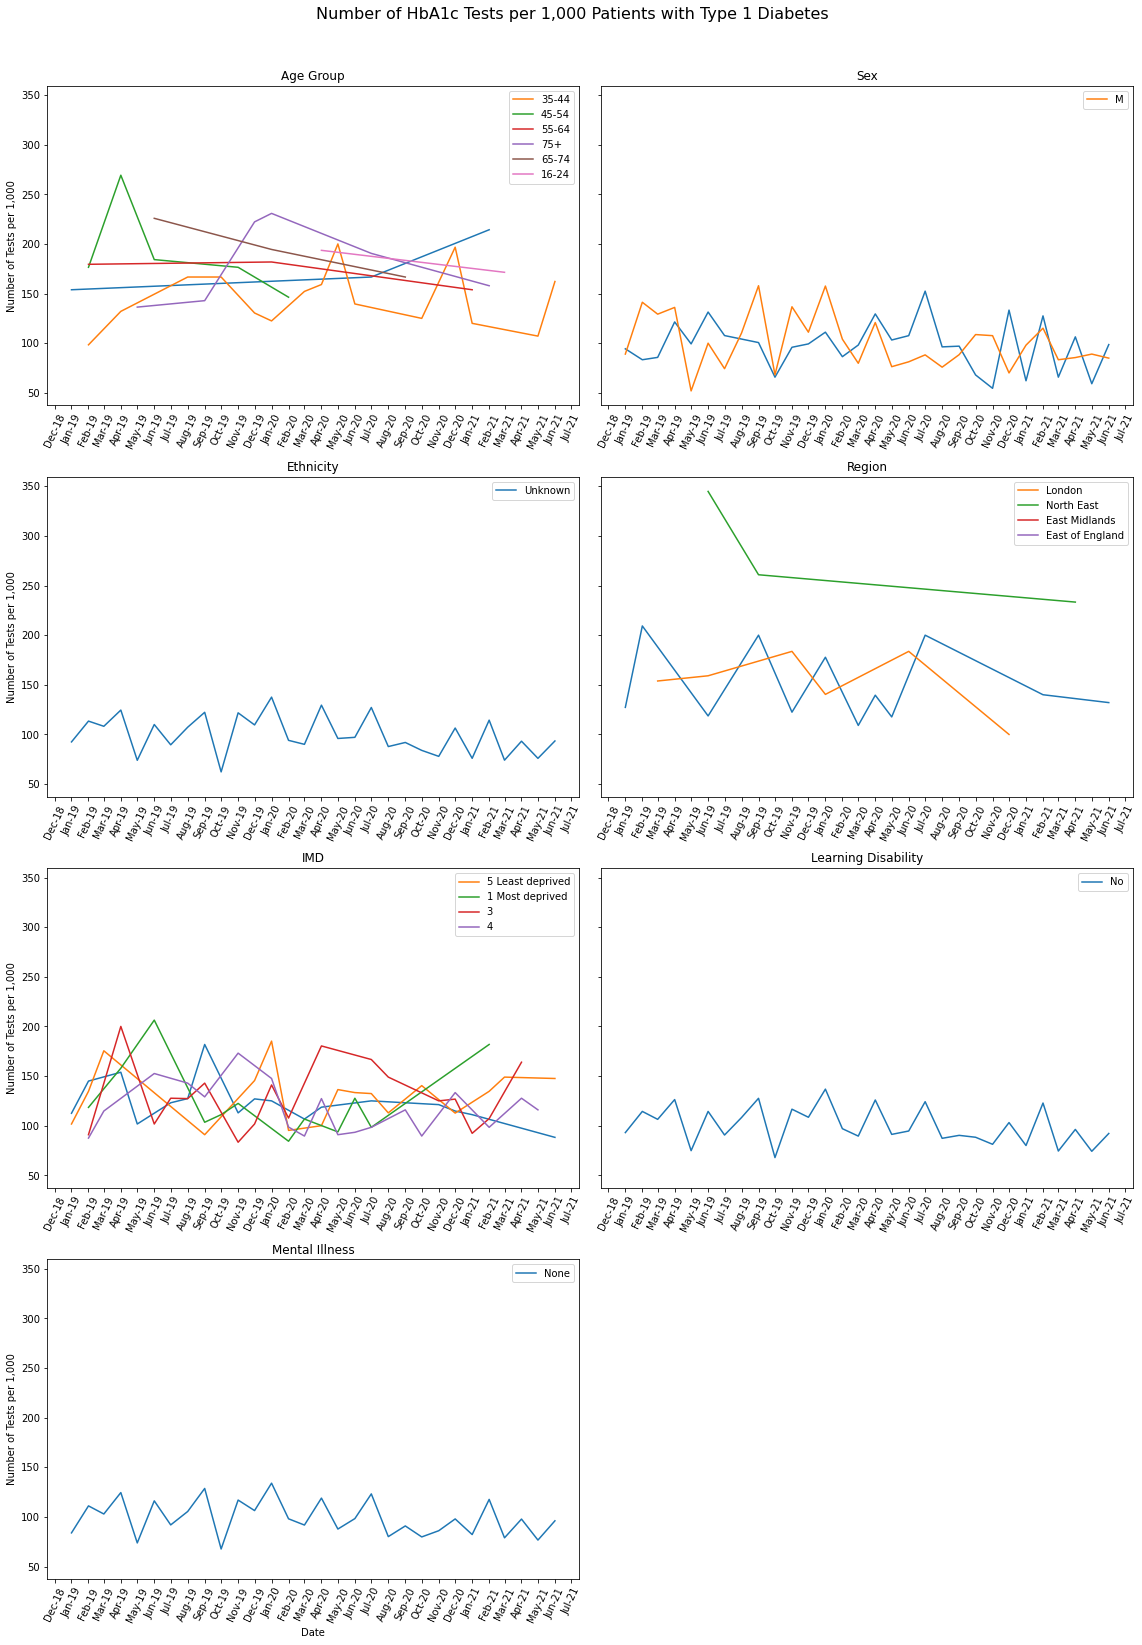

In [12]:
# Patients with T1DM
create_plotgrid('tests_per_1000',li_df_t1dm, 'Number of Tests per 1,000',
                'total_t1dm_by_group', 'Number of HbA1c Tests per 1,000 Patients with Type 1 Diabetes')

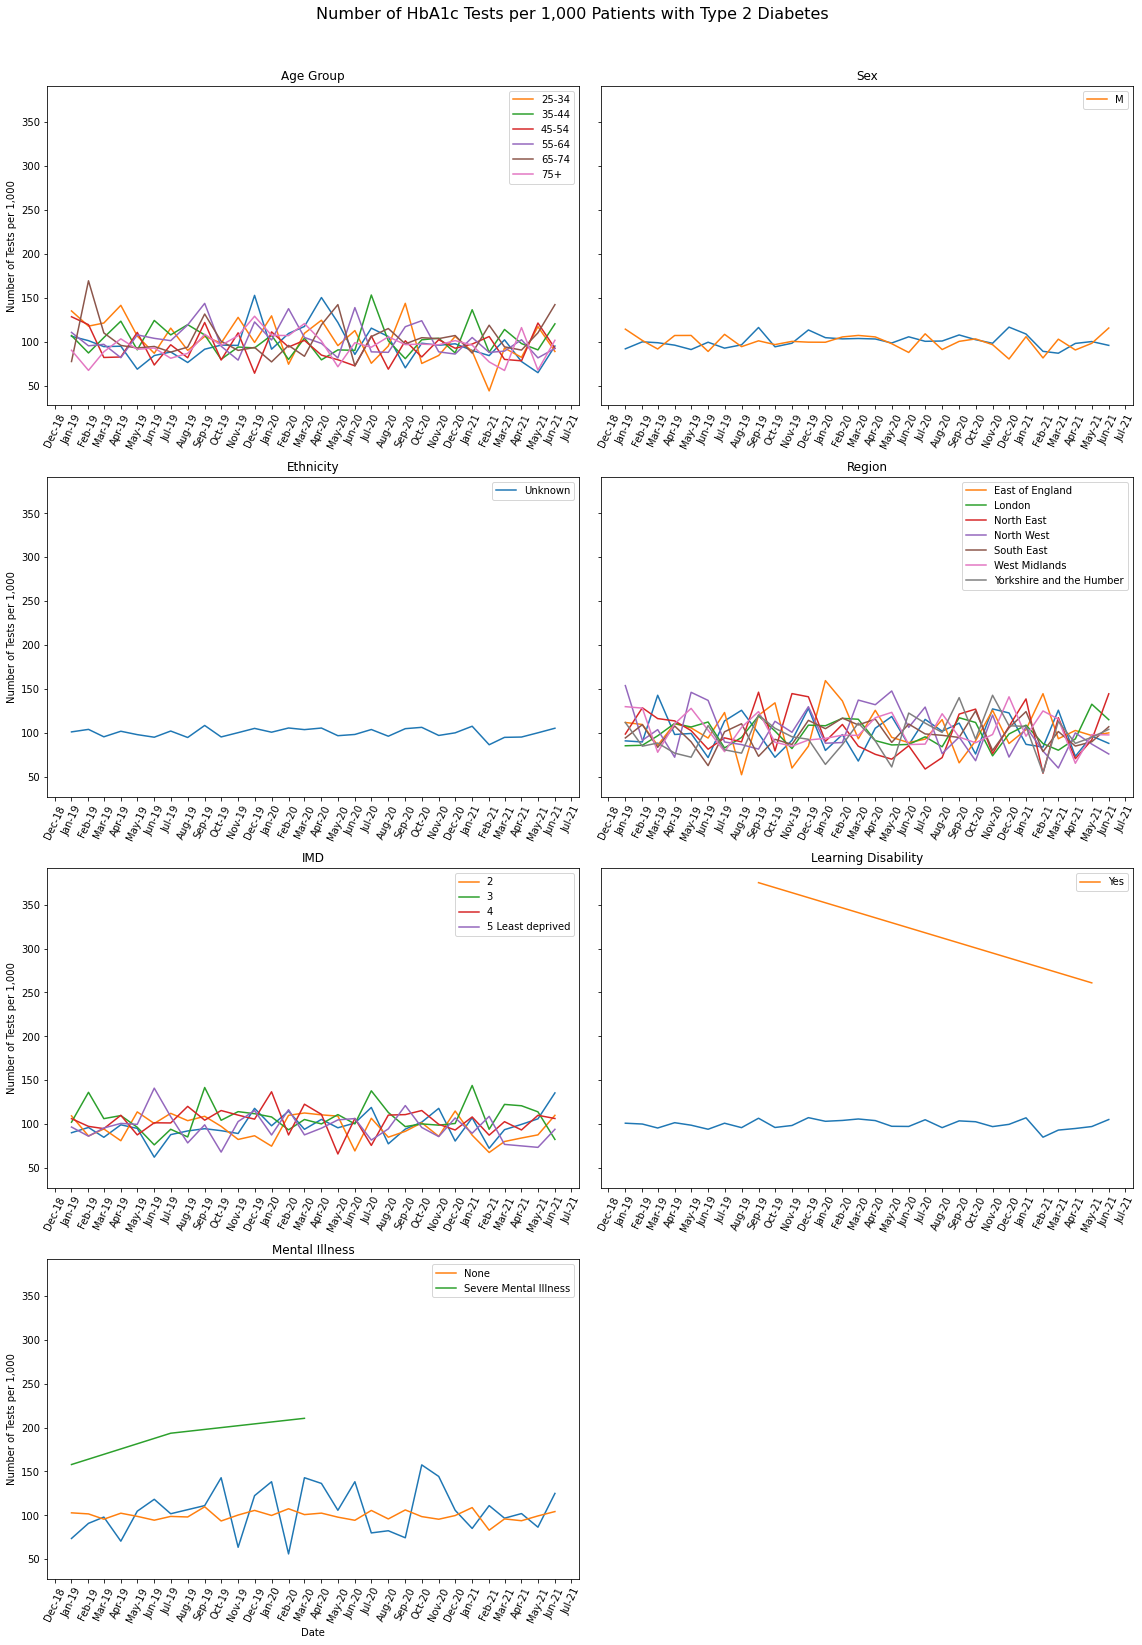

In [13]:
# Patients with T2DM
create_plotgrid('tests_per_1000', li_df_t2dm, 'Number of Tests per 1,000',
                'total_t2dm_by_group', 'Number of HbA1c Tests per 1,000 Patients with Type 2 Diabetes')

_________

## Tests by Threshold for Those with T2DM

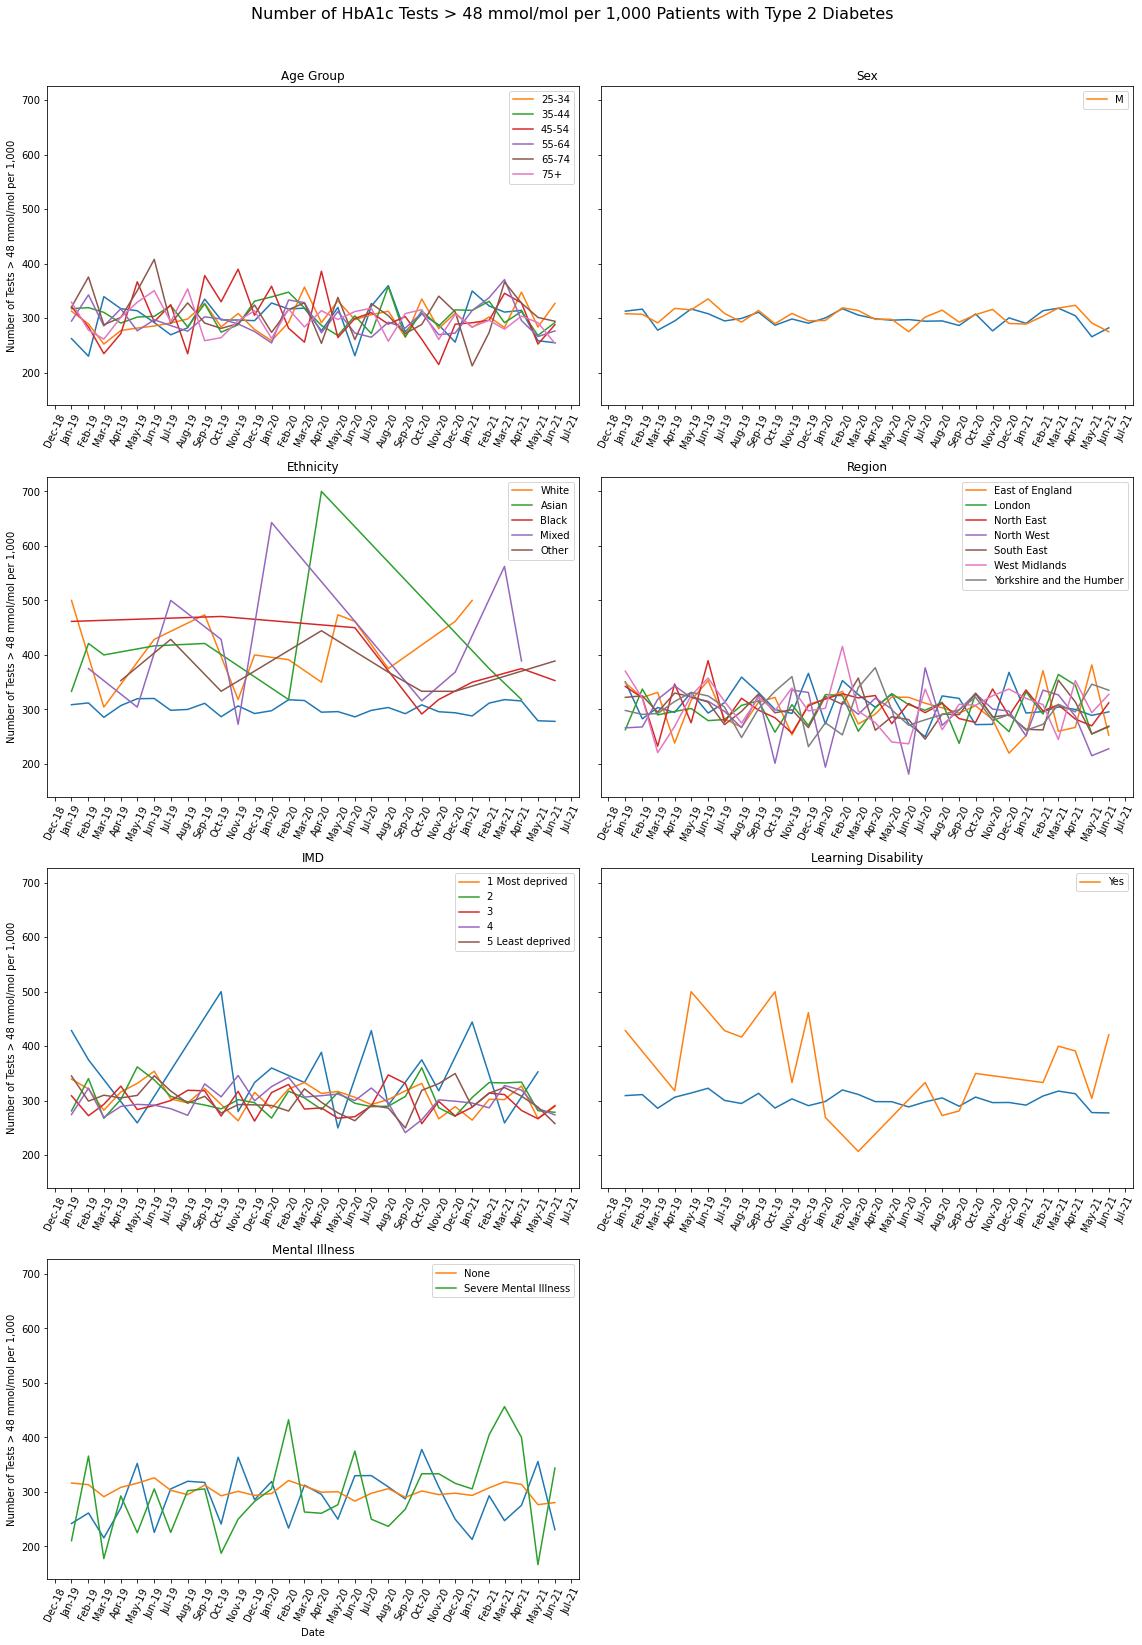

In [14]:
# > 48
create_plotgrid('tests_per_1000',li_df_t2dm_gt48, 'Number of Tests > 48 mmol/mol per 1,000',
                'gt48_t2dm_by_group', 'Number of HbA1c Tests > 48 mmol/mol per 1,000 Patients with Type 2 Diabetes')

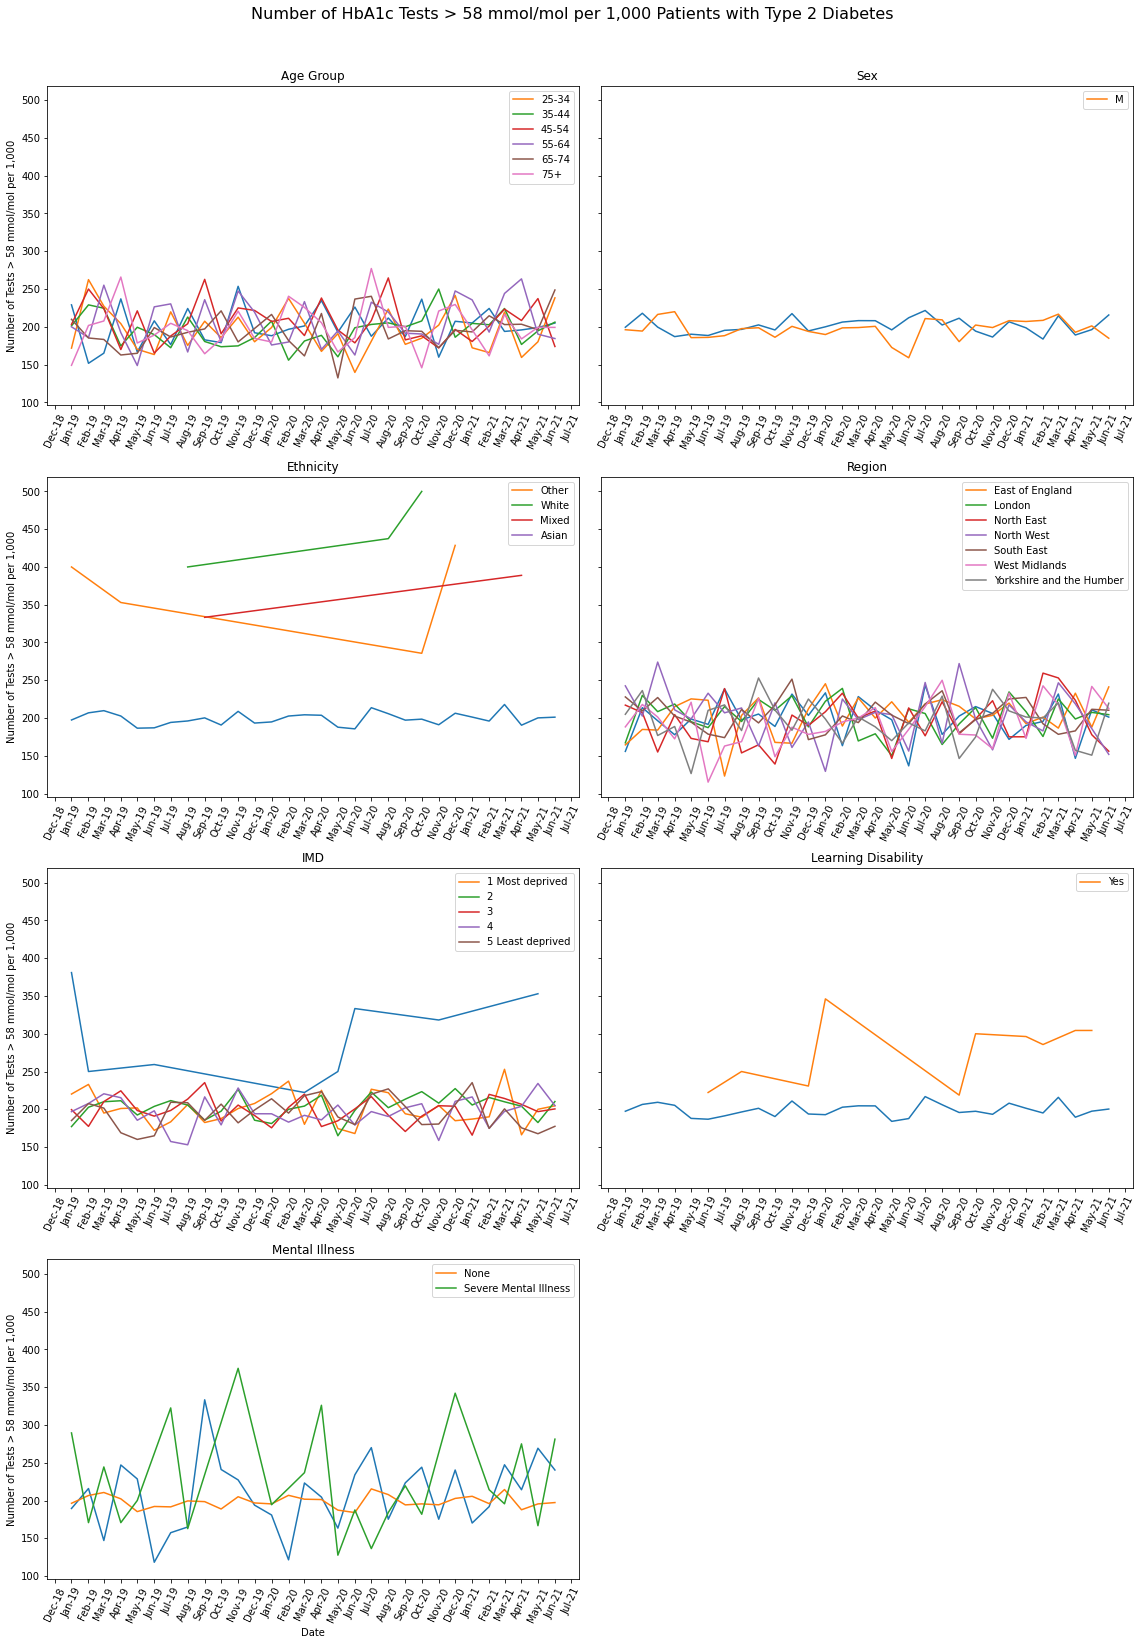

In [15]:
# > 58
create_plotgrid('tests_per_1000',li_df_t2dm_gt58, 'Number of Tests > 58 mmol/mol per 1,000',
                'gt58_t2dm_by_group', 'Number of HbA1c Tests > 58 mmol/mol per 1,000 Patients with Type 2 Diabetes')

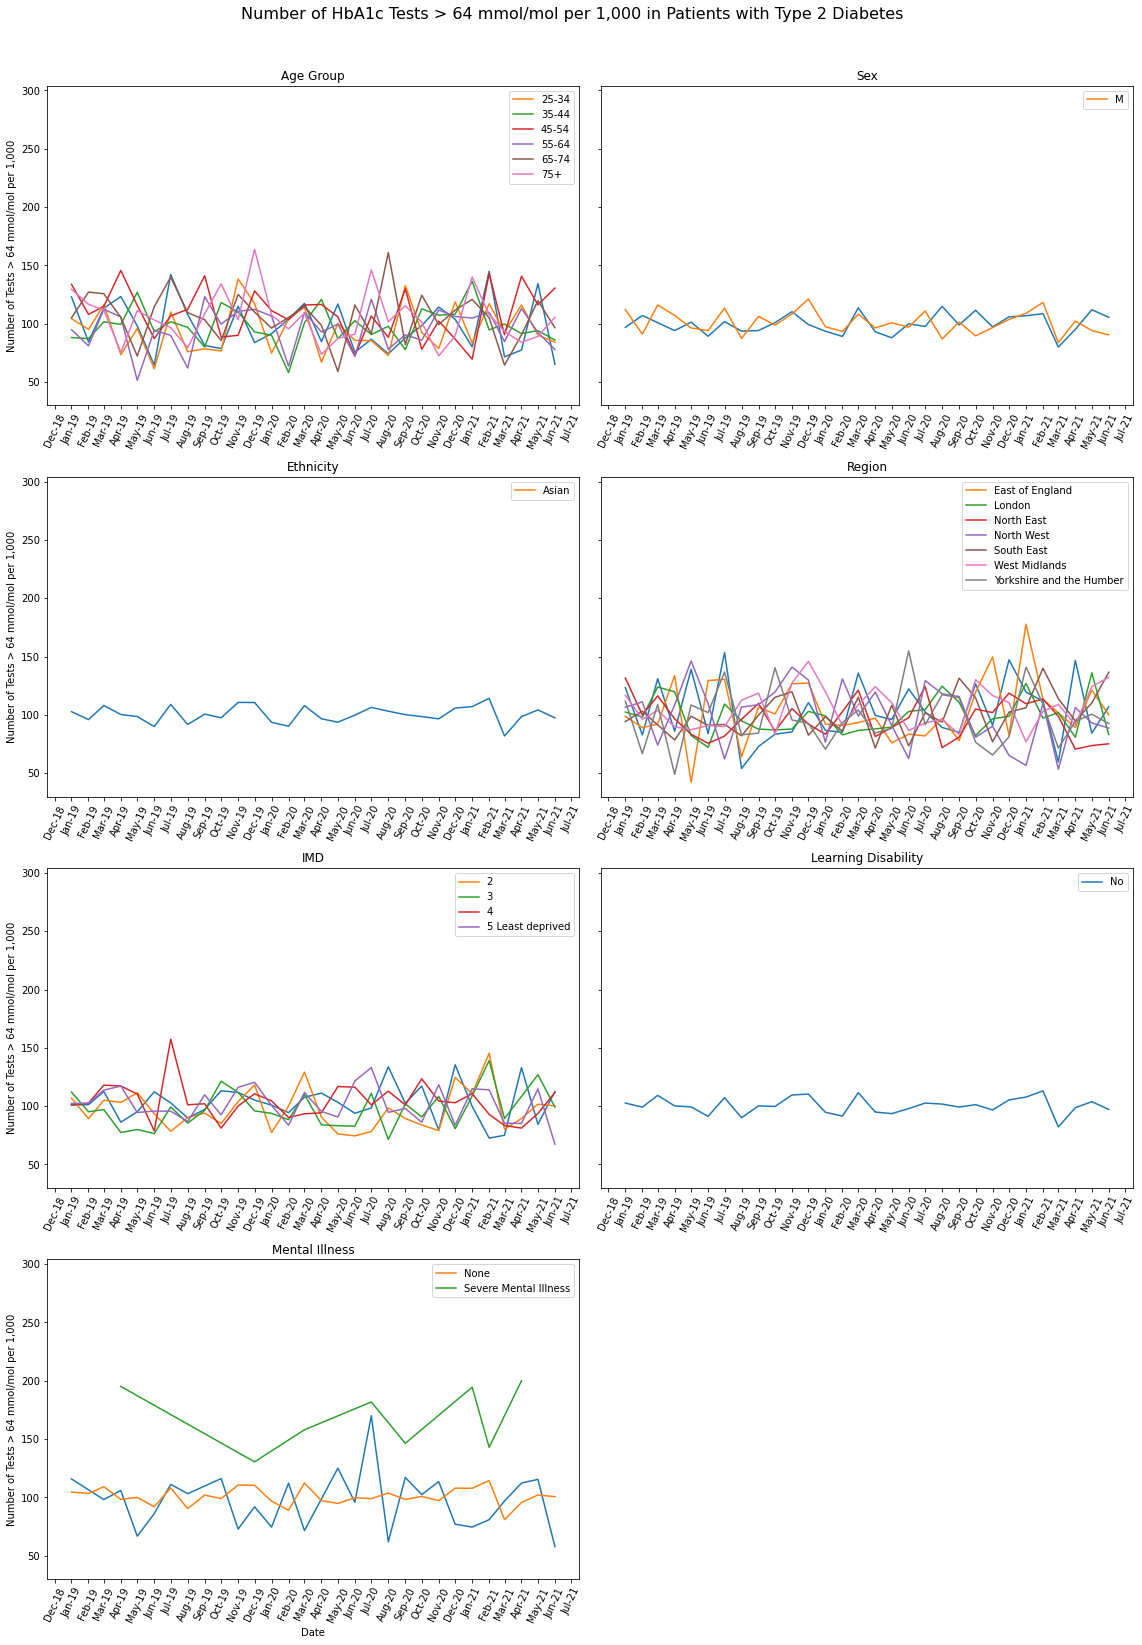

In [16]:
# > 64
create_plotgrid('tests_per_1000',li_df_t2dm_gt64, 'Number of Tests > 64 mmol/mol per 1,000',
                'gt64_t2dm_by_group','Number of HbA1c Tests > 64 mmol/mol per 1,000 in Patients with Type 2 Diabetes')

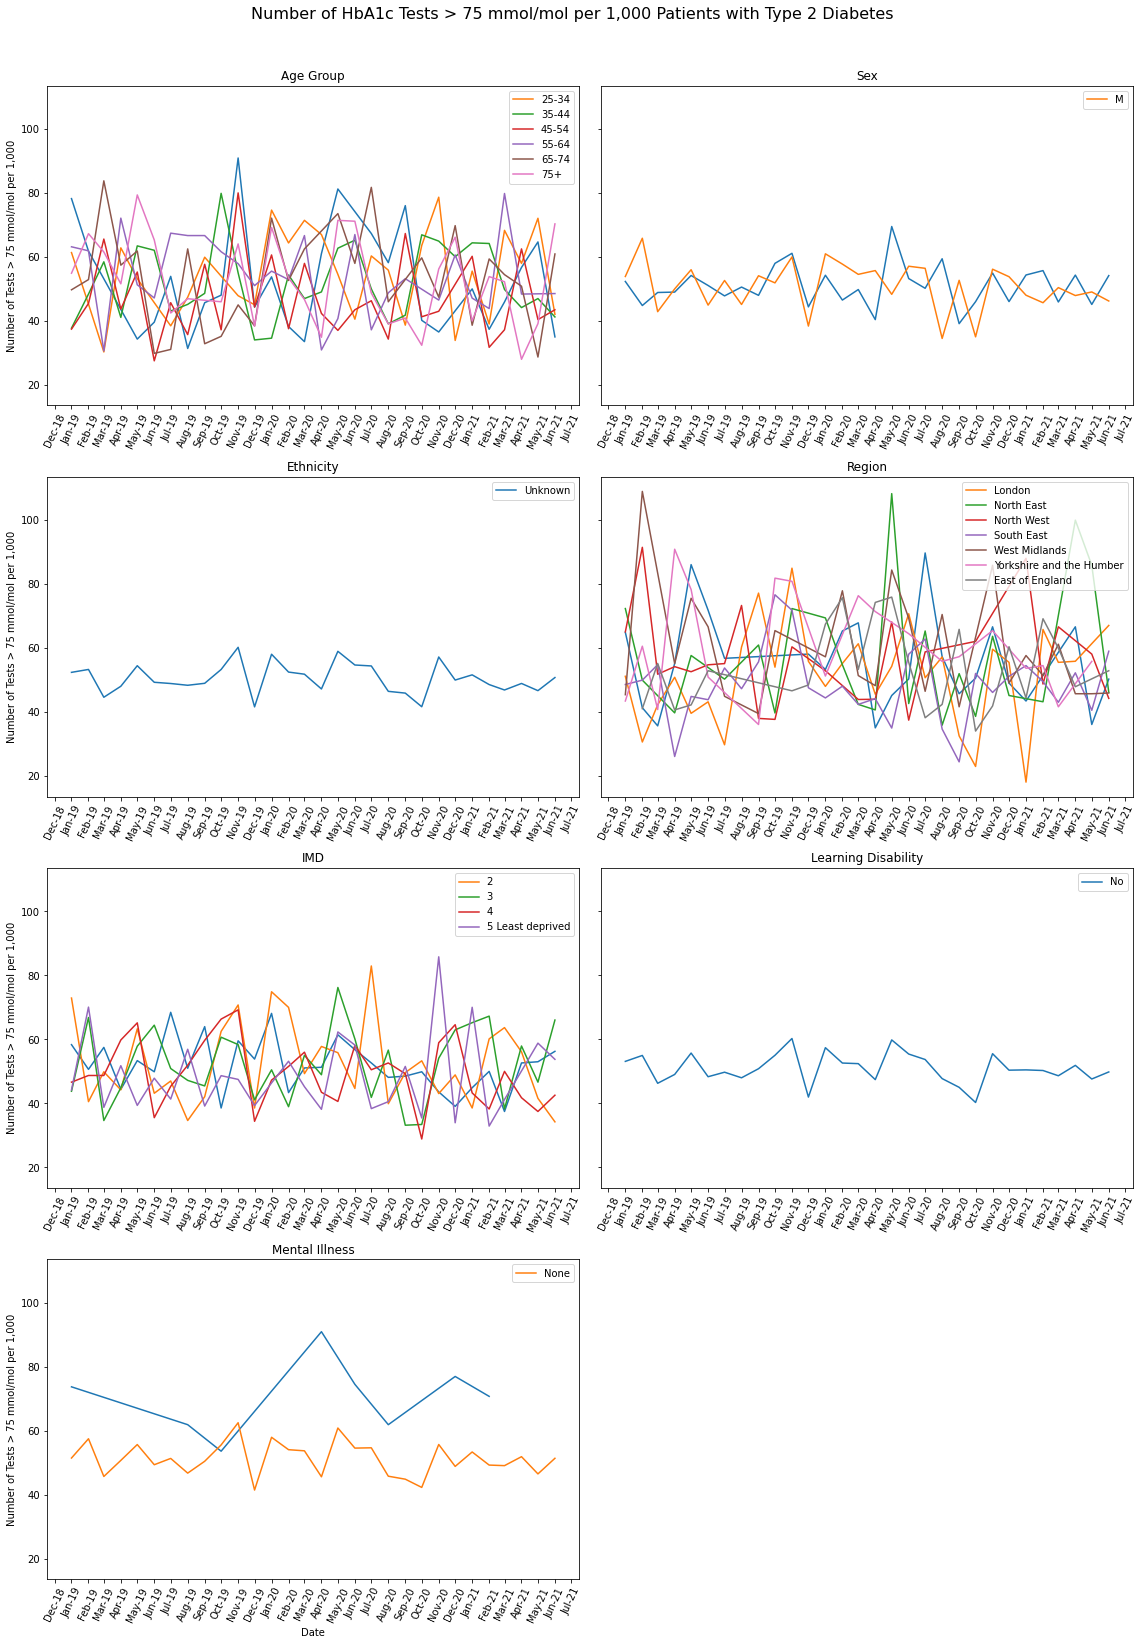

In [17]:
# > 75
create_plotgrid('tests_per_1000',li_df_t2dm_gt75, 'Number of Tests > 75 mmol/mol per 1,000',
                'gt75_t2dm_by_group','Number of HbA1c Tests > 75 mmol/mol per 1,000 Patients with Type 2 Diabetes')

___

## Percent of Tests by Target Threshold

In [18]:
# Subset to percentage variables
df_t2dm_pct = df_total_t2dm[['date','hba1c_gt_48_pct','hba1c_gt_58_pct',
                            'hba1c_gt_64_pct', 'hba1c_gt_75_pct']]

In [19]:
# Wide to long
df_t2dm_pct_wide = pd.melt(df_t2dm_pct, id_vars=['date'], value_vars=['hba1c_gt_48_pct','hba1c_gt_58_pct',
                                                                      'hba1c_gt_64_pct', 'hba1c_gt_75_pct']).reset_index(drop=True)

In [20]:
# Format variable
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_48_pct', 'variable'] = '> 48 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_58_pct', 'variable'] = '> 58 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_64_pct', 'variable'] = '> 64 mmol/mol'
df_t2dm_pct_wide.loc[df_t2dm_pct_wide.variable == 'hba1c_gt_75_pct', 'variable'] = '> 75 mmol/mol'
df_t2dm_pct_wide = df_t2dm_pct_wide.rename(columns={'variable':'threshold'})

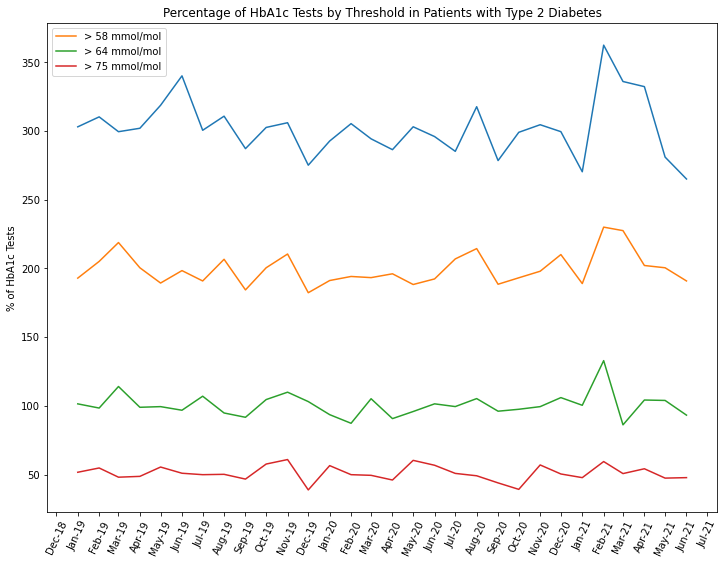

In [21]:
# Create total plot
fig, ax = plt.subplots(figsize=(12,9))

sns.lineplot(x='date', y='value',
             hue='threshold', data=df_t2dm_pct_wide)
    
# Set title and make axes labels empty
ax.set_title('Percentage of HbA1c Tests by Threshold in Patients with Type 2 Diabetes')
ax.set_xlabel('')
ax.set_ylabel('% of HbA1c Tests')
ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=65)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y'))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
plt.savefig('../output/pct_t2dm.png')
plt.show()

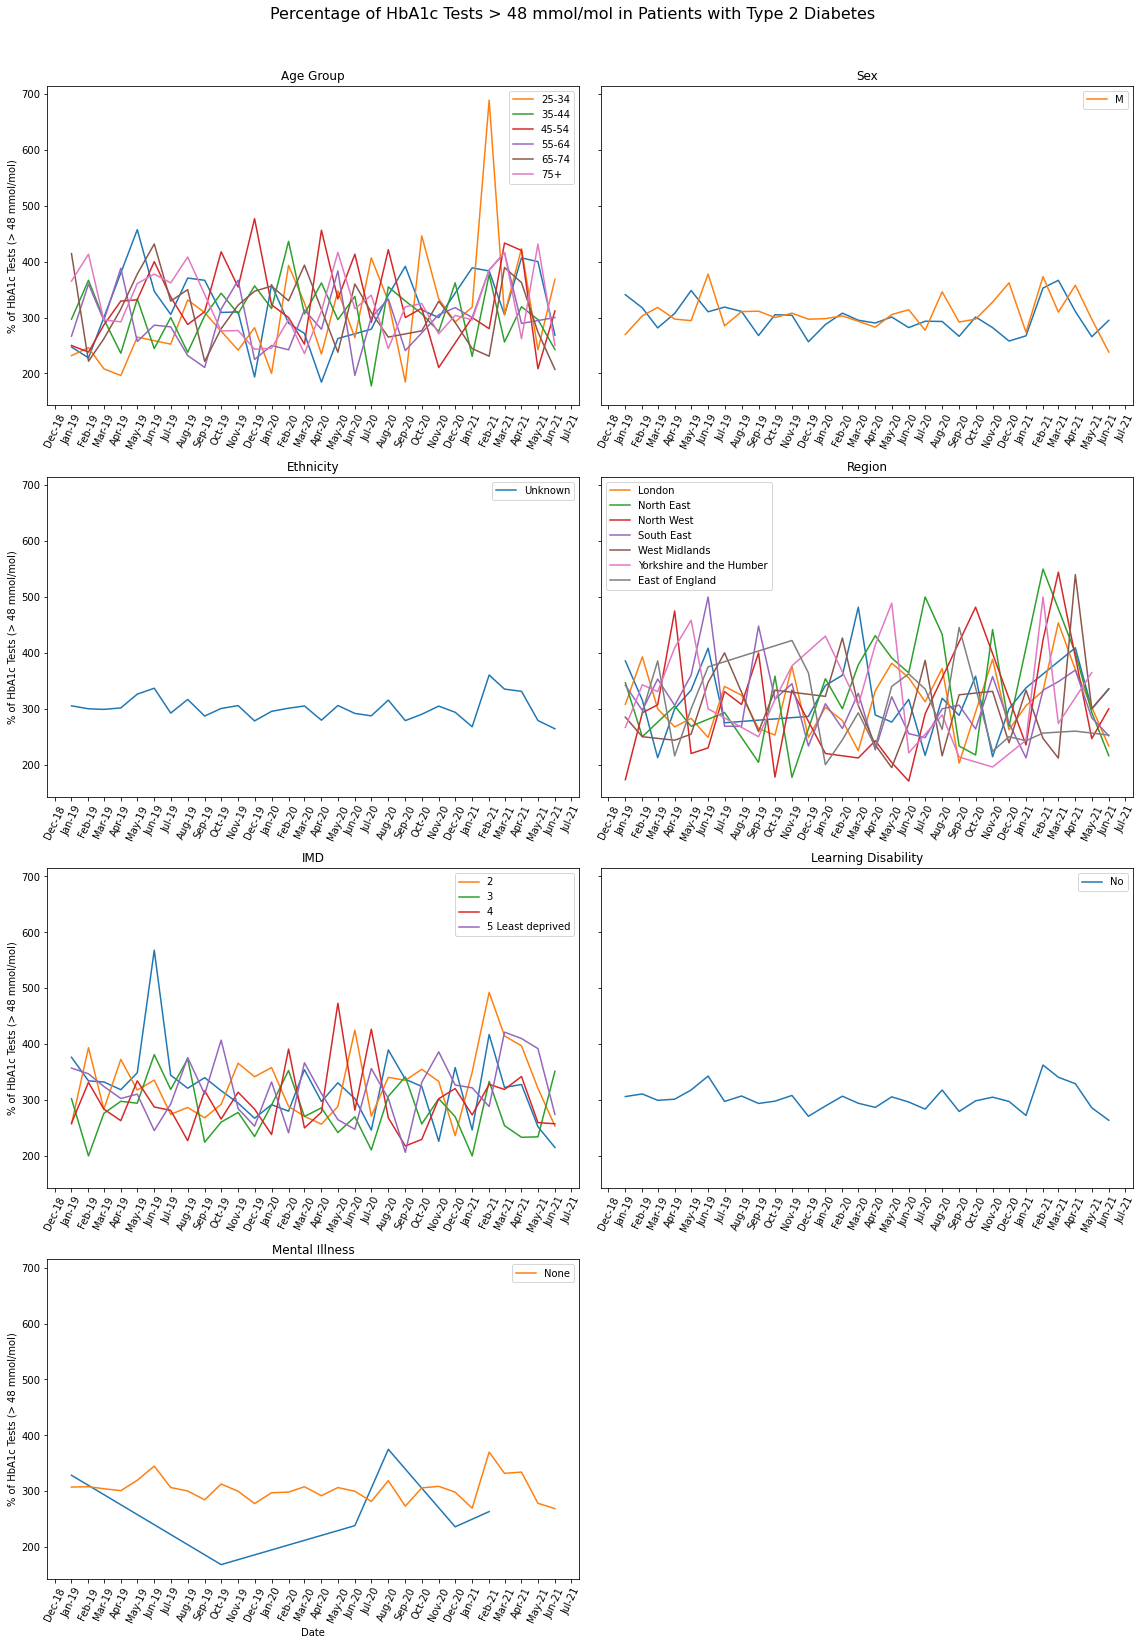

In [22]:
# > 48
create_plotgrid('hba1c_gt_48_pct',df_thresholds, '% of HbA1c Tests (> 48 mmol/mol)',
                'pct_t2dm_gt48','Percentage of HbA1c Tests > 48 mmol/mol in Patients with Type 2 Diabetes')

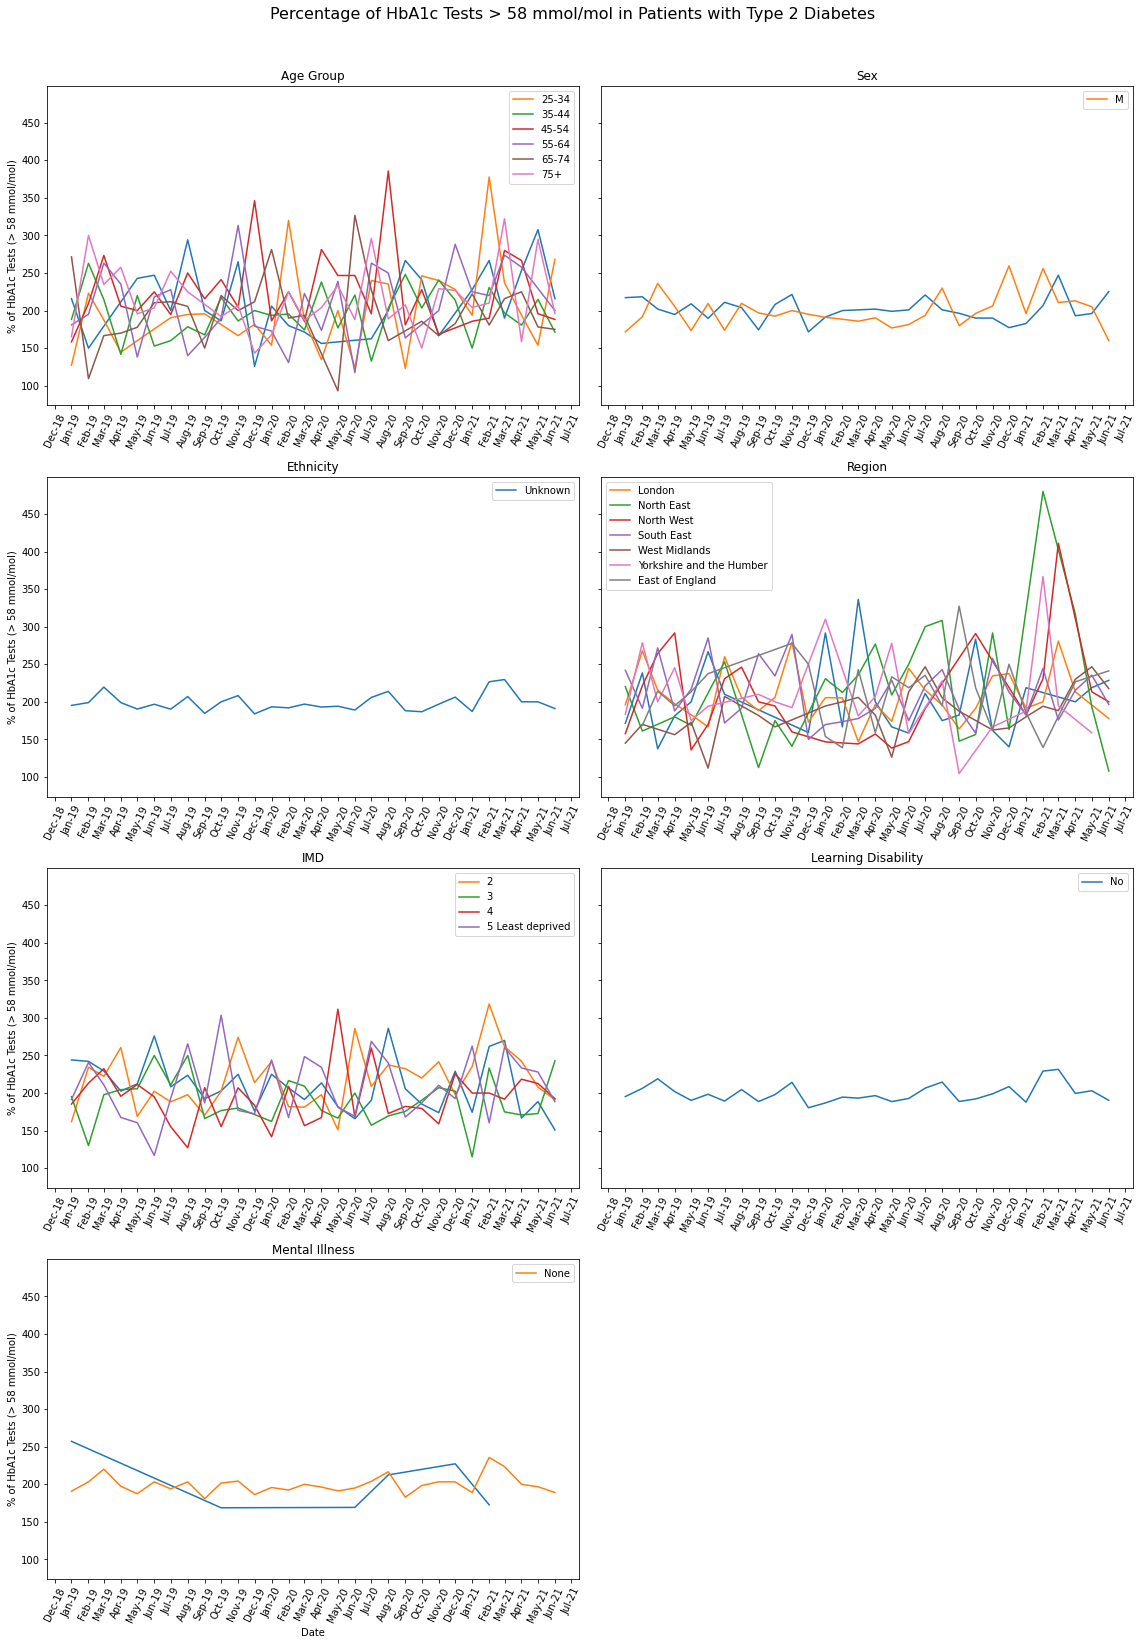

In [23]:
# > 58
create_plotgrid('hba1c_gt_58_pct',df_thresholds, '% of HbA1c Tests (> 58 mmol/mol)',
                'pct_t2dm_gt58', 'Percentage of HbA1c Tests > 58 mmol/mol in Patients with Type 2 Diabetes')

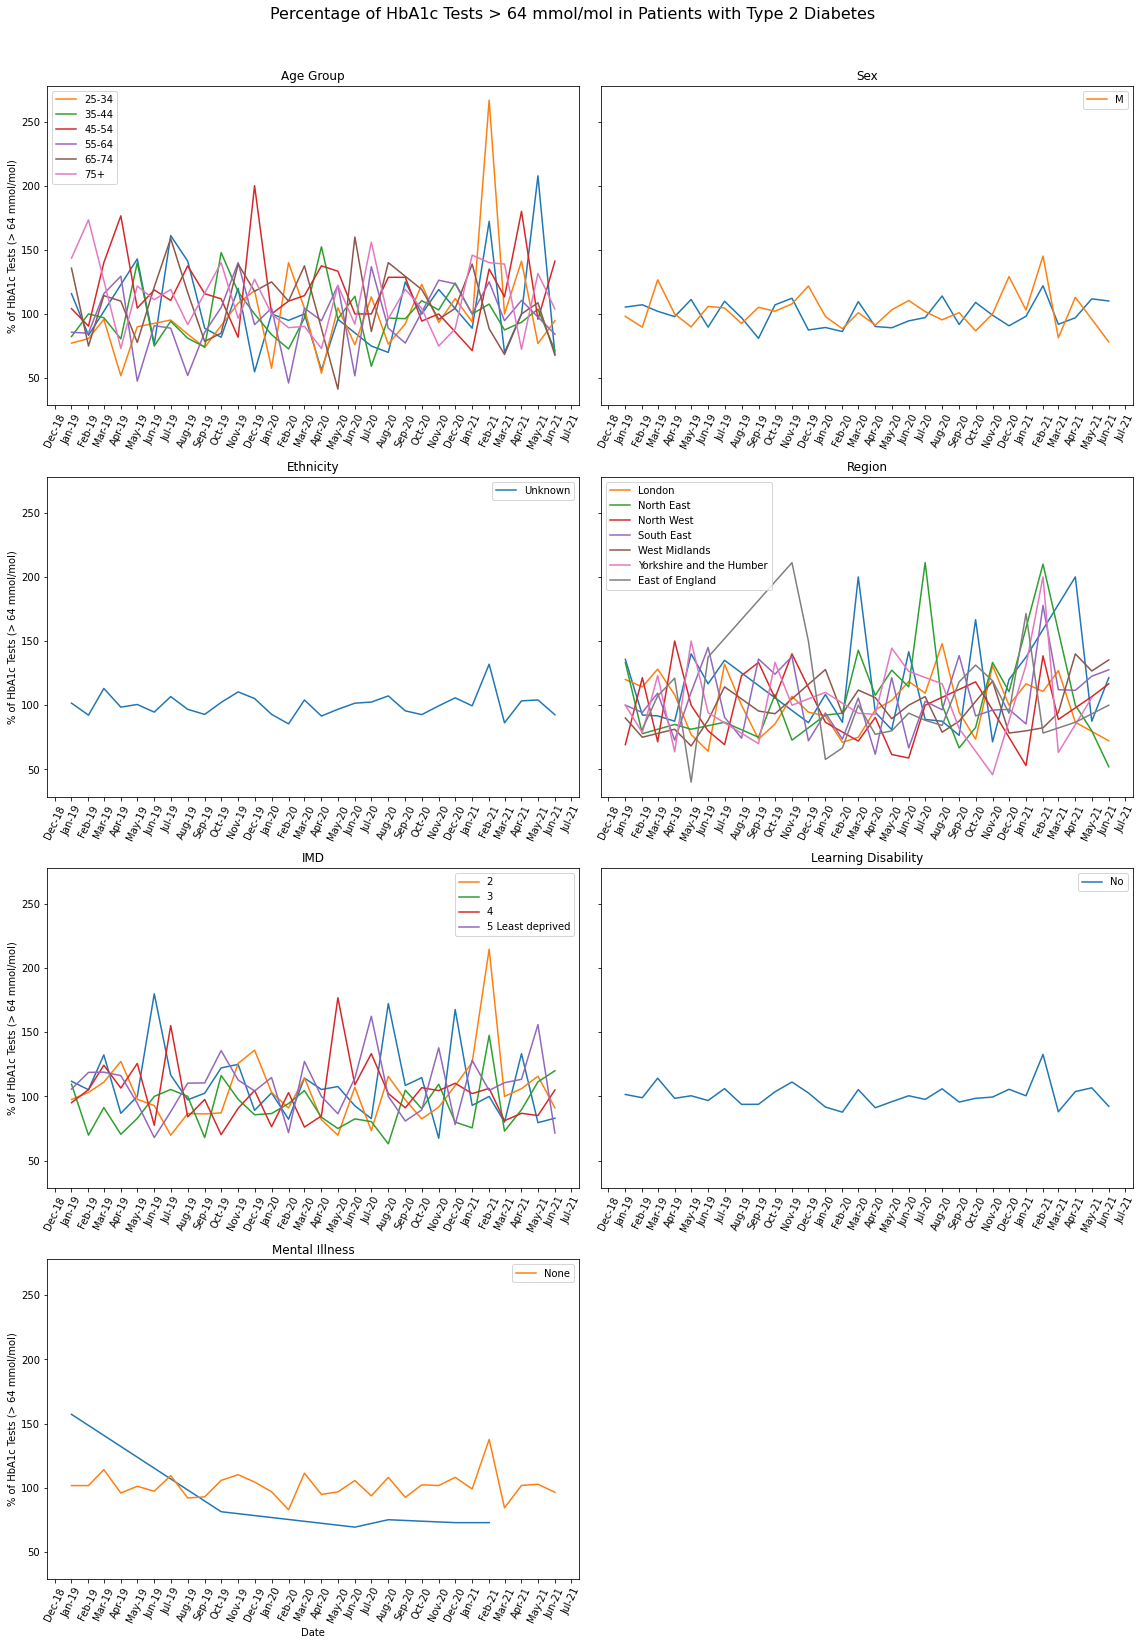

In [24]:
# > 64
create_plotgrid('hba1c_gt_64_pct',df_thresholds, '% of HbA1c Tests (> 64 mmol/mol)',
                'pct_t2dm_gt64', 'Percentage of HbA1c Tests > 64 mmol/mol in Patients with Type 2 Diabetes')

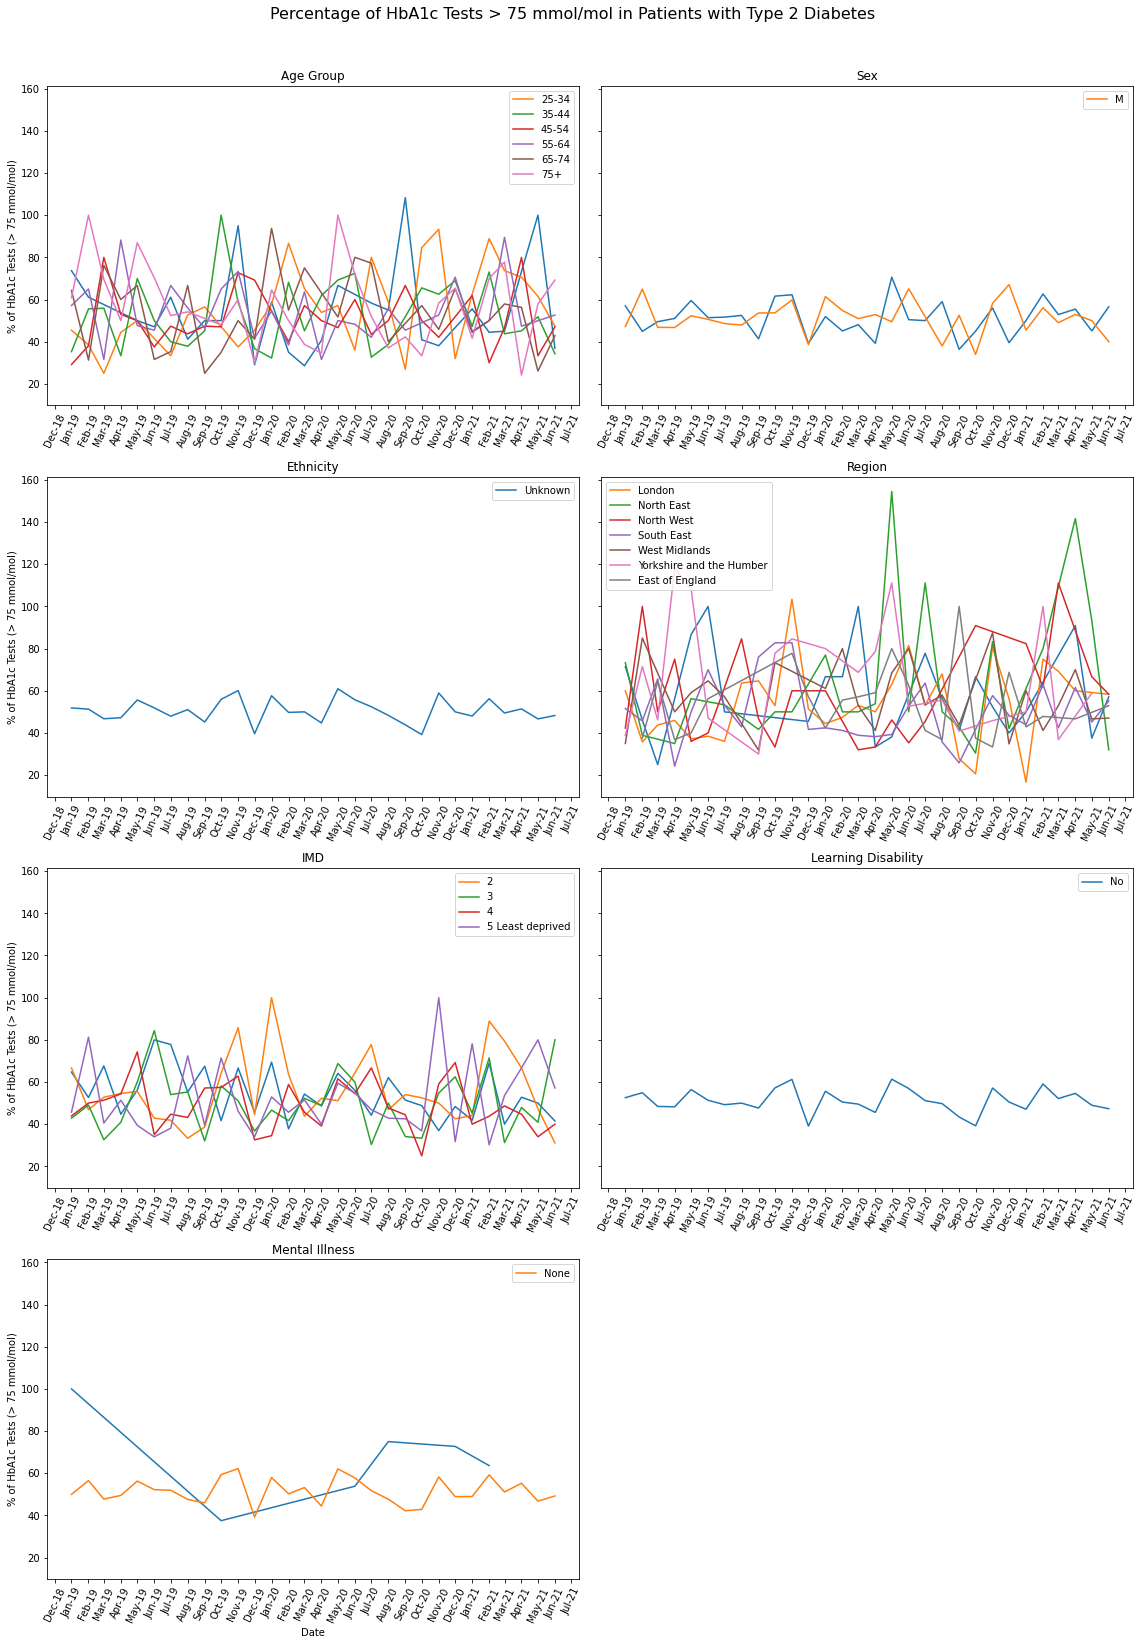

In [25]:
# > 75
create_plotgrid('hba1c_gt_75_pct',df_thresholds, '% of HbA1c Tests (> 75 mmol/mol)',
                'pct_t2dm_gt75', 'Percentage of HbA1c Tests > 75 mmol/mol in Patients with Type 2 Diabetes')

______

## Number of Tests in Patients with Elevated HbA1c Pre-pandemic

In [26]:
def import_subset(d):    
    df = pd.read_csv(f"{fpath}/calc_{d}.csv", index_col=0)
    df['date'] = df['date'].apply(lambda x: datetime.strptime(x.strip(), '%Y-%m-%d'))
    return df

df_t2dm_elev = import_subset('t2dm_elev')
df_t2dm_elev_age = import_subset('t2dm_elev_age')
df_t2dm_elev_sex = import_subset('t2dm_elev_sex')
df_t2dm_elev_eth = import_subset('t2dm_elev_eth')
df_t2dm_elev_reg = import_subset('t2dm_elev_reg')
df_t2dm_elev_imd = import_subset('t2dm_elev_imd')
df_t2dm_elev_ld = import_subset('t2dm_elev_ld')
df_t2dm_elev_mi = import_subset('t2dm_elev_mi')

In [27]:
elev_ct_dfs = [df_t2dm_elev, df_t2dm_elev_age, df_t2dm_elev_sex, 
               df_t2dm_elev_eth, df_t2dm_elev_reg, df_t2dm_elev_imd,
               df_t2dm_elev_ld, df_t2dm_elev_mi]

cts = ['tests_per_1000', 'gt48_per_1000','gt58_per_1000','gt64_per_1000','gt75_per_1000']

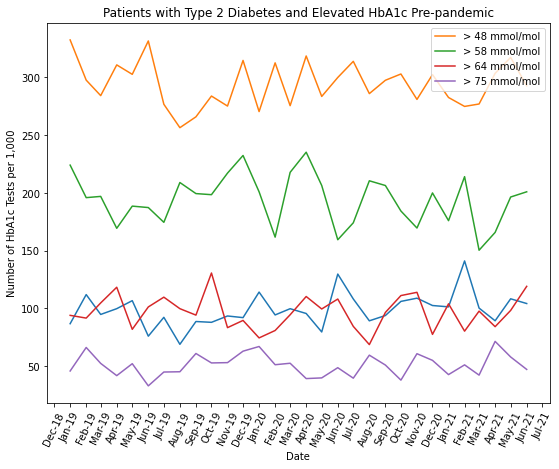

In [28]:
dict_col_rename = {'tests_per_1000':'Total','gt48_per_1000':'> 48 mmol/mol',
                   'gt58_per_1000':'> 58 mmol/mol','gt64_per_1000':'> 64 mmol/mol',
                   'gt75_per_1000':'> 75 mmol/mol'}

plt_cols = ['Total','> 48 mmol/mol','> 58 mmol/mol','> 64 mmol/mol','> 75 mmol/mol']

fig, ax = plt.subplots(figsize=(9, 7))
create_chart('Patients with Type 2 Diabetes and Elevated HbA1c Pre-pandemic', 
             df_t2dm_elev.rename(columns=dict_col_rename), plt_cols, ax)

### By Demographics

In [29]:
# List of value change dfs
li_df_t2dm_elev = [df_t2dm_elev_age, df_t2dm_elev_sex, df_t2dm_elev_eth,
                   df_t2dm_elev_reg, df_t2dm_elev_imd, df_t2dm_elev_ld, 
                   df_t2dm_elev_mi]

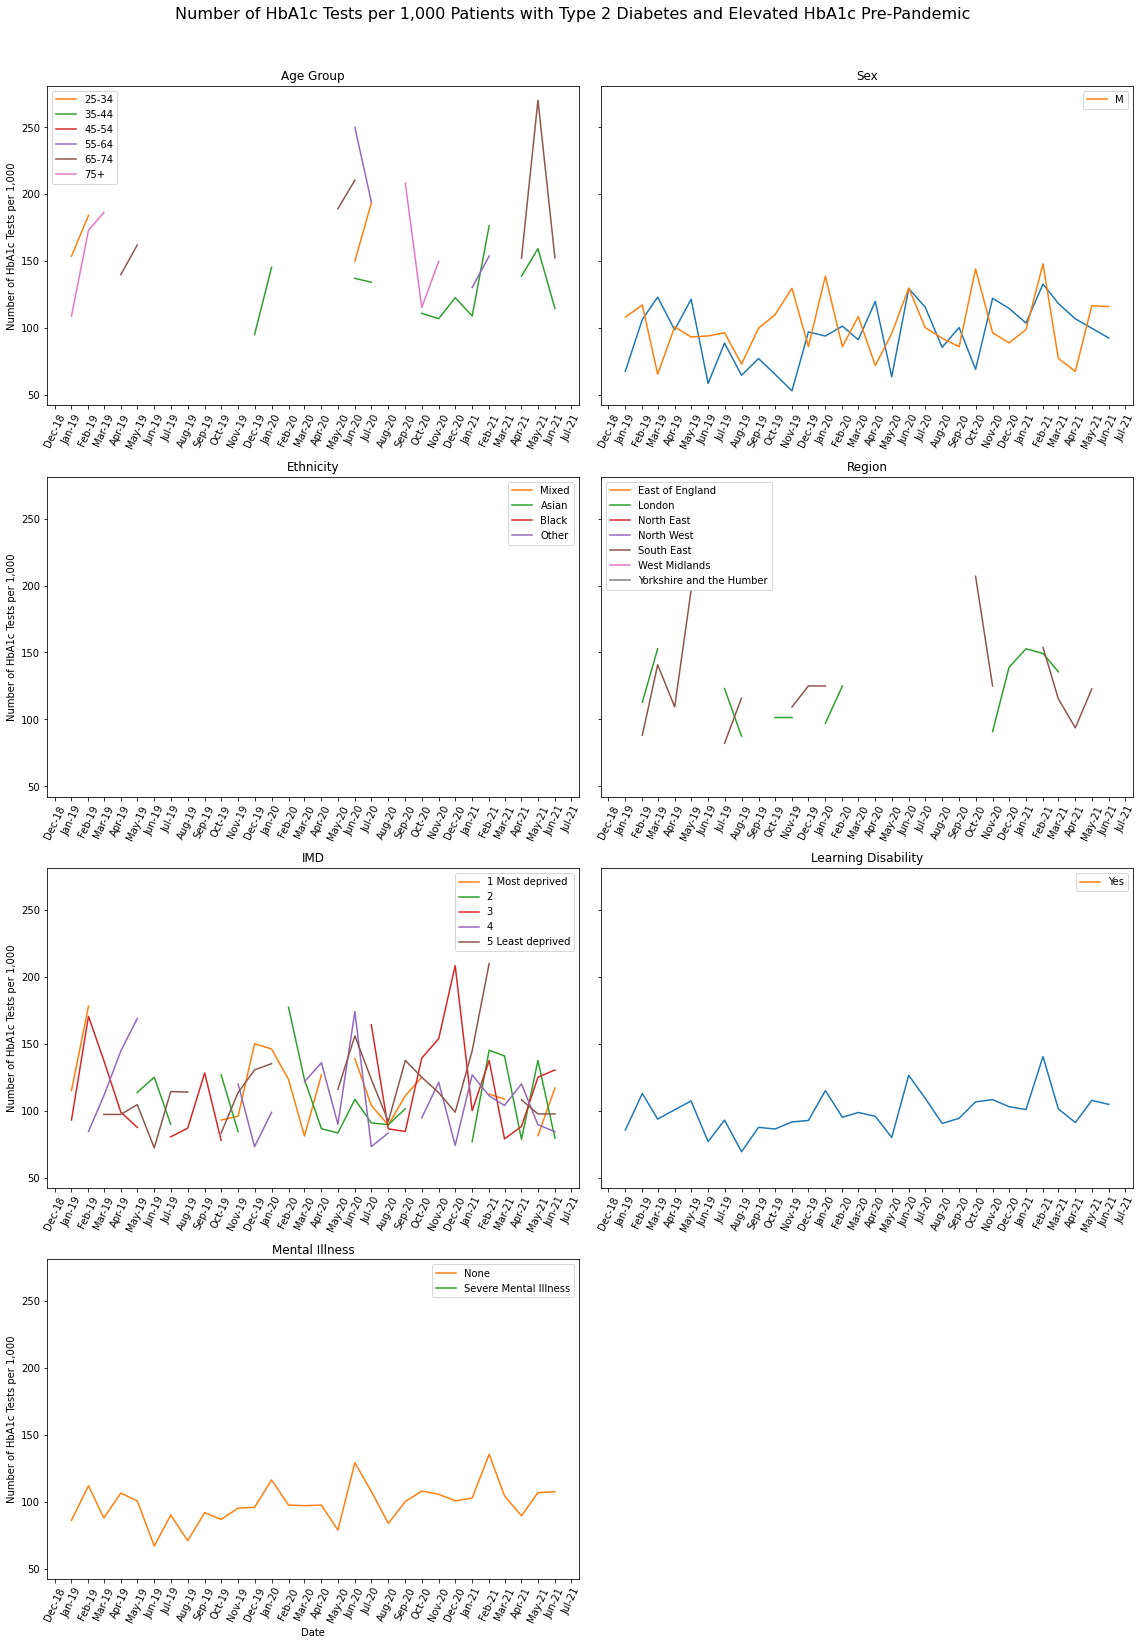

In [30]:
# Total tests
create_plotgrid('tests_per_1000', li_df_t2dm_elev, 'Number of HbA1c Tests per 1,000', 'elev_total',
                'Number of HbA1c Tests per 1,000 Patients with Type 2 Diabetes and Elevated HbA1c Pre-Pandemic')

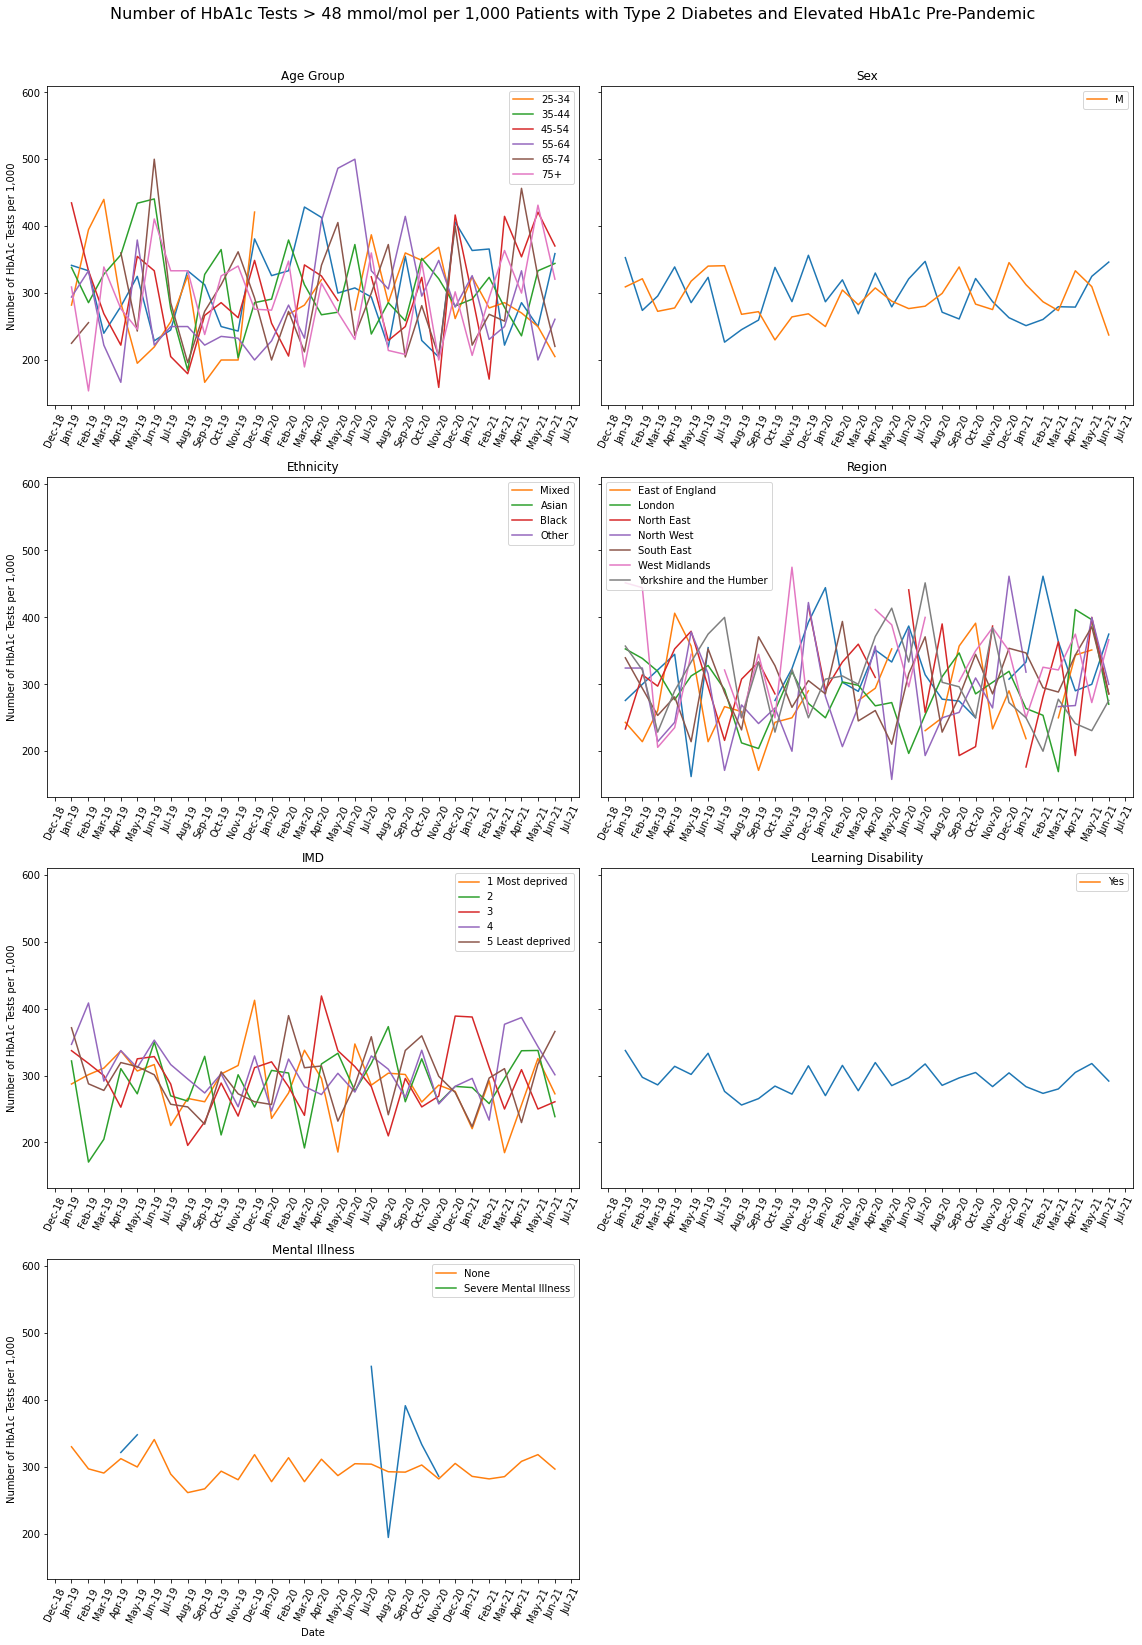

In [31]:
# 48 mmol/mol
create_plotgrid('gt48_per_1000', li_df_t2dm_elev, 'Number of HbA1c Tests per 1,000','elev_gt_48',
                'Number of HbA1c Tests > 48 mmol/mol per 1,000 Patients with Type 2 Diabetes and Elevated HbA1c Pre-Pandemic')

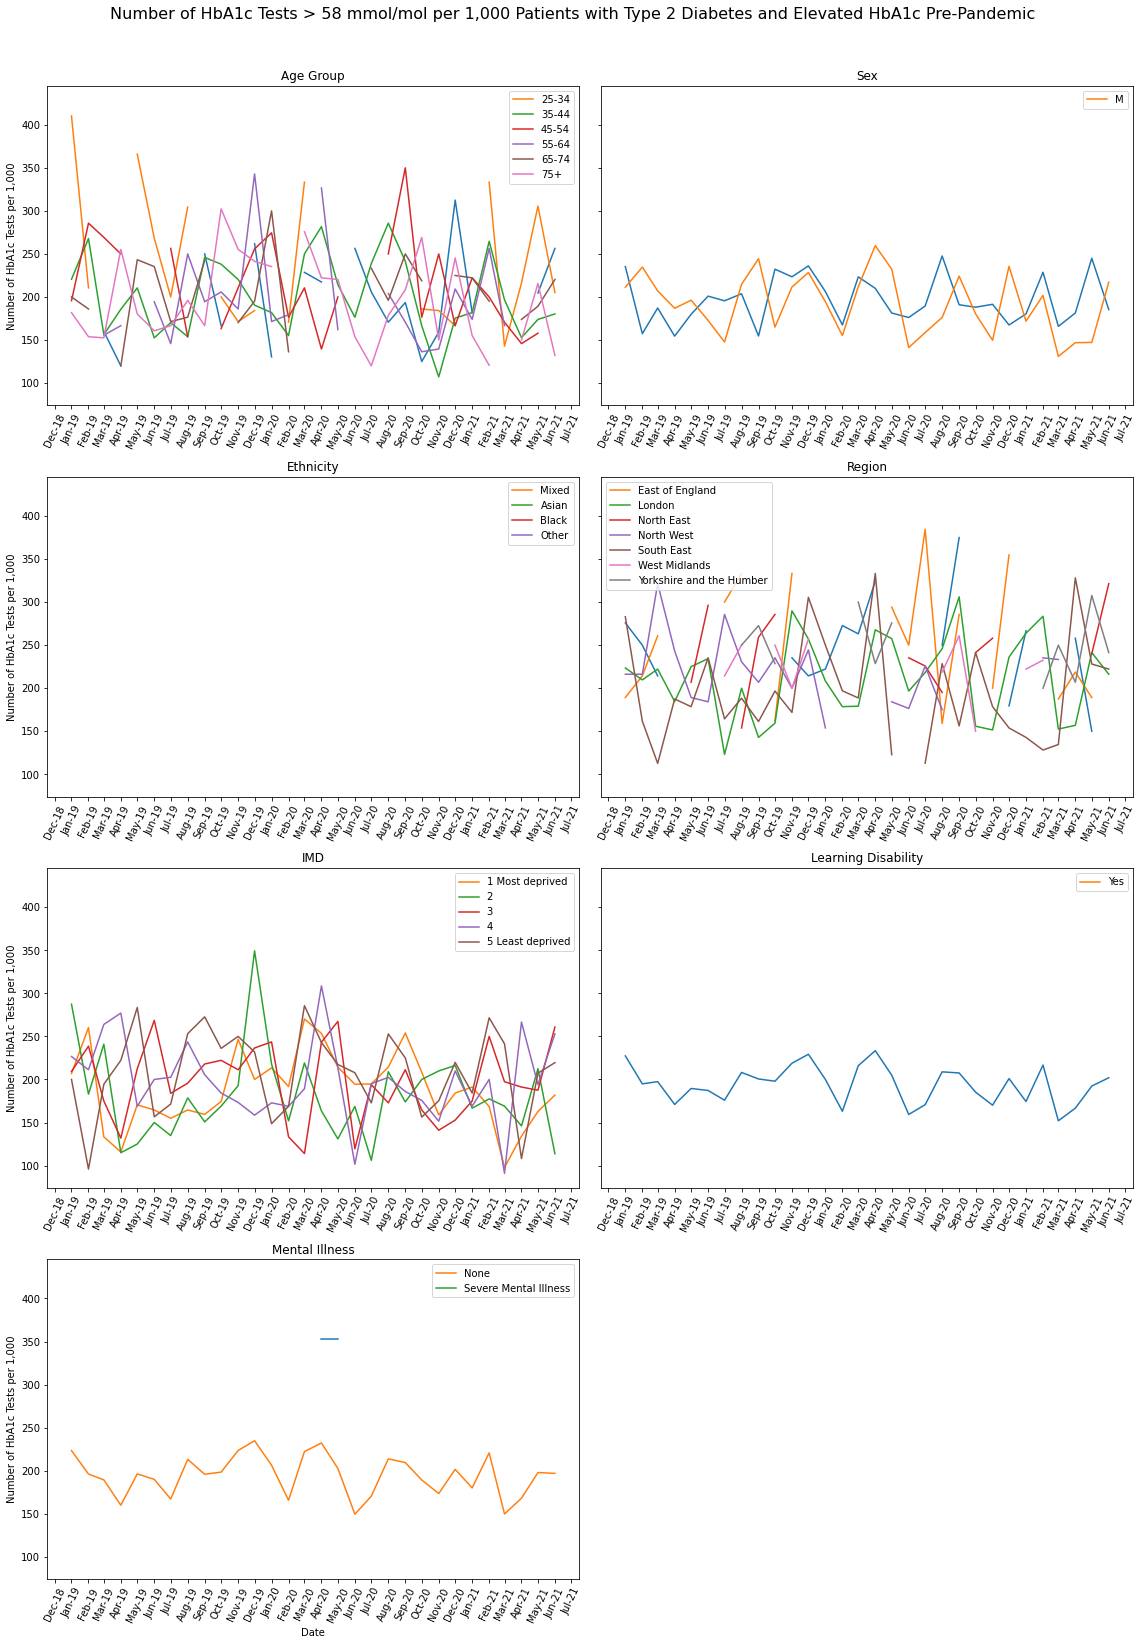

In [32]:
# 58 mmol/mol
create_plotgrid('gt58_per_1000', li_df_t2dm_elev, 'Number of HbA1c Tests per 1,000','elev_gt_58',
                'Number of HbA1c Tests > 58 mmol/mol per 1,000 Patients with Type 2 Diabetes and Elevated HbA1c Pre-Pandemic')

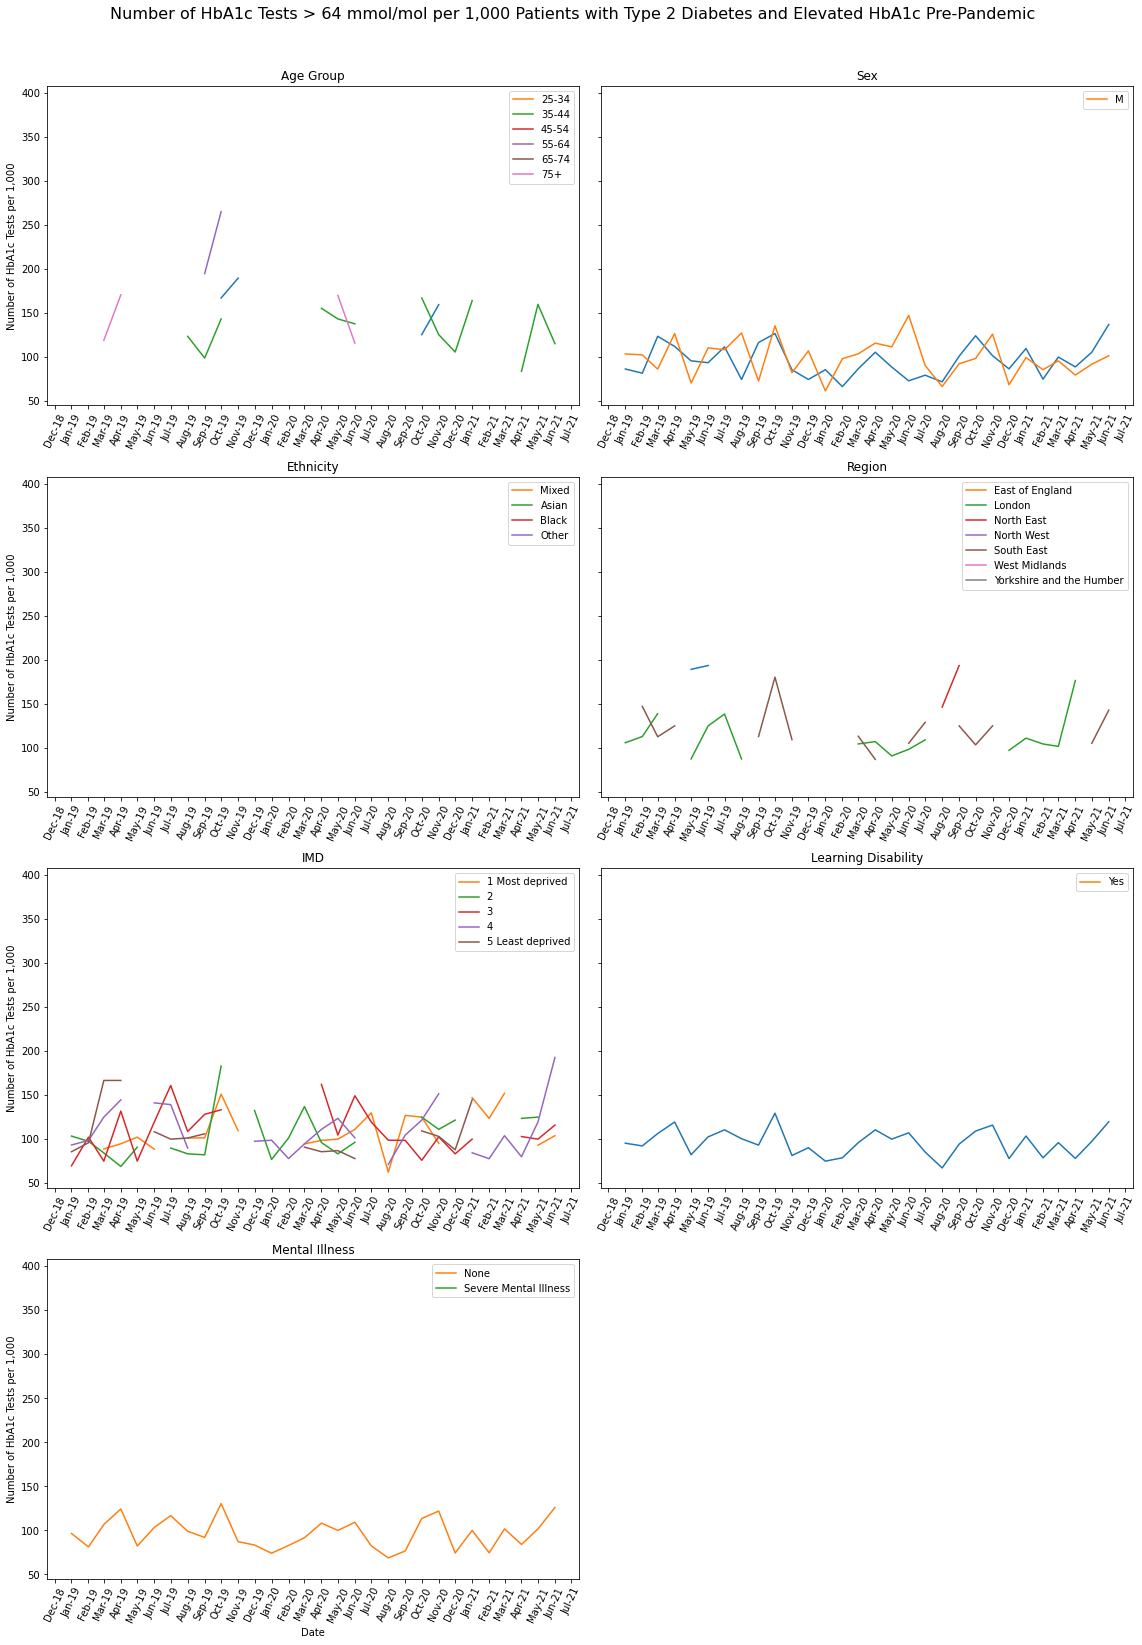

In [33]:
# 64 mmol/mol
create_plotgrid('gt64_per_1000', li_df_t2dm_elev, 'Number of HbA1c Tests per 1,000','elev_gt_64',
                'Number of HbA1c Tests > 64 mmol/mol per 1,000 Patients with Type 2 Diabetes and Elevated HbA1c Pre-Pandemic')

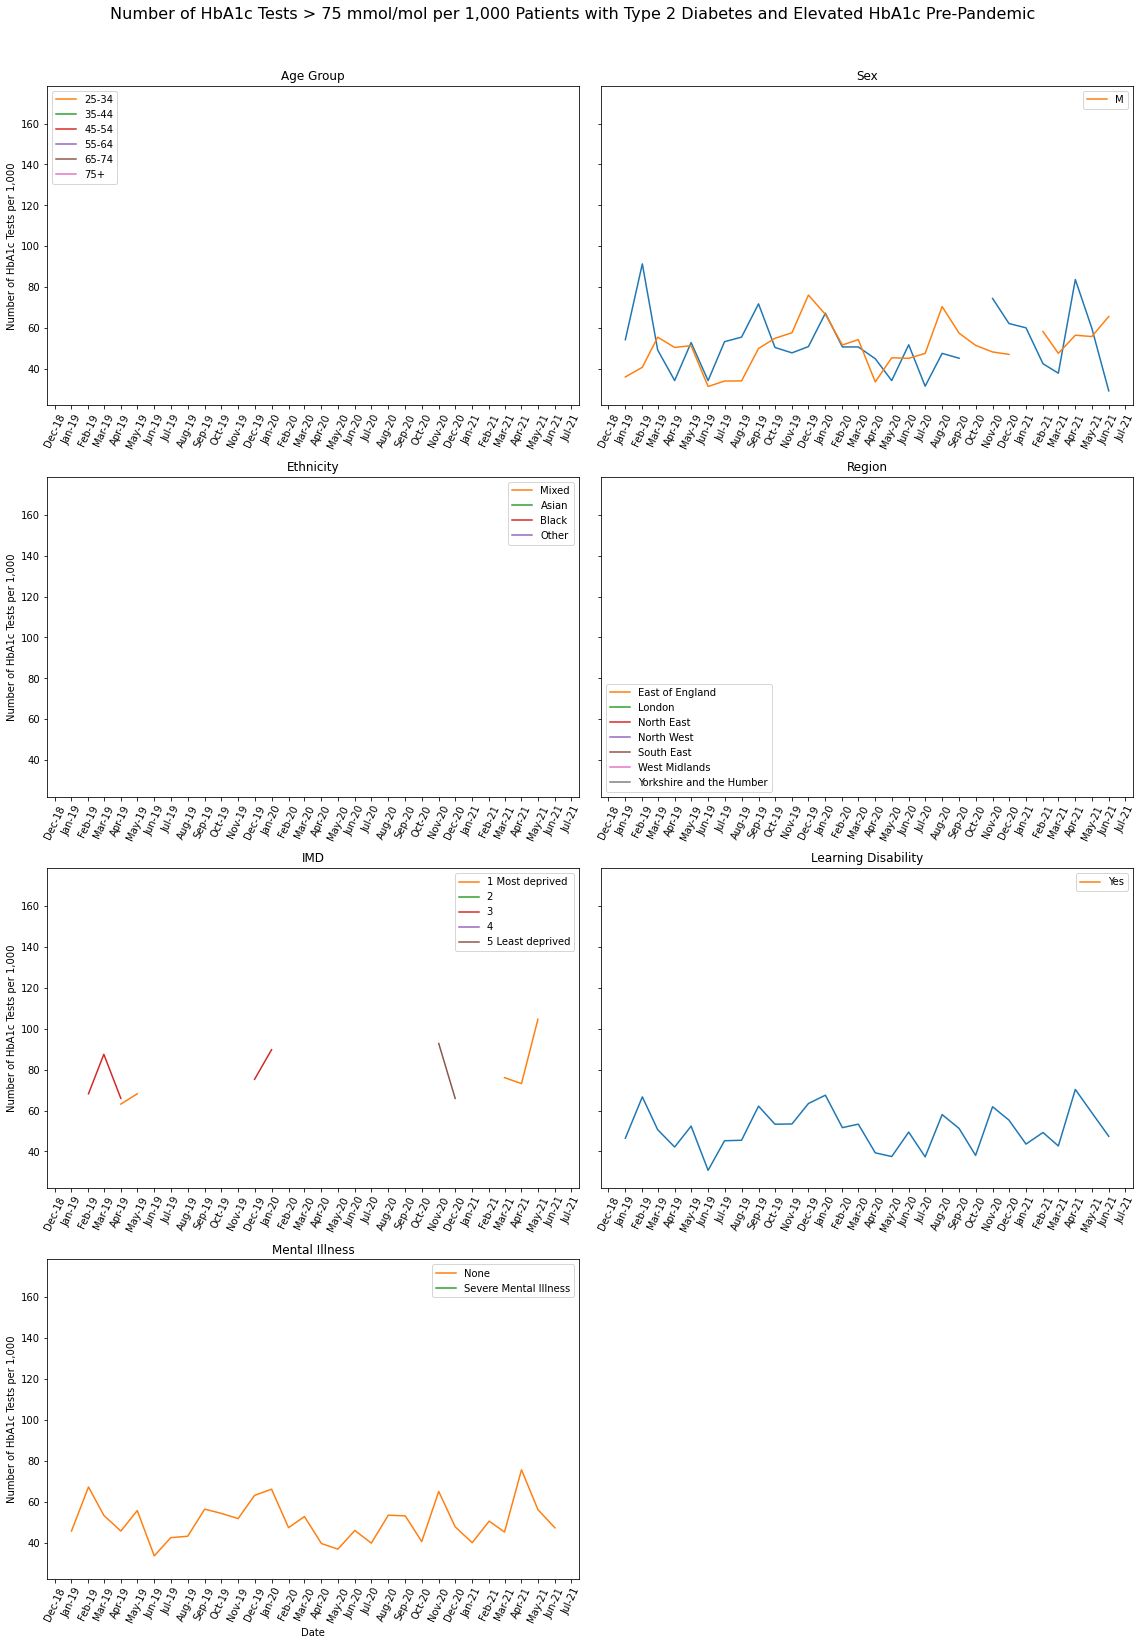

In [34]:
# 75 mmol/mol
create_plotgrid('gt75_per_1000', li_df_t2dm_elev, 'Number of HbA1c Tests per 1,000','elev_gt_75',
                'Number of HbA1c Tests > 75 mmol/mol per 1,000 Patients with Type 2 Diabetes and Elevated HbA1c Pre-Pandemic')

________

## Number of Tests in Patients with Prediabetes Pre-pandemic

In [35]:
df_predm = import_subset('predm')
df_predm_age = import_subset('predm_age')
df_predm_sex = import_subset('predm_sex')
df_predm_eth = import_subset('predm_eth')
df_predm_reg = import_subset('predm_reg')
df_predm_imd = import_subset('predm_imd')
df_predm_ld = import_subset('predm_ld')
df_predm_mi = import_subset('predm_mi')

In [36]:
predm_ct_dfs = [df_predm, df_predm_age, df_predm_sex, 
                df_predm_eth, df_predm_reg, df_predm_imd,
                df_predm_ld, df_predm_mi]

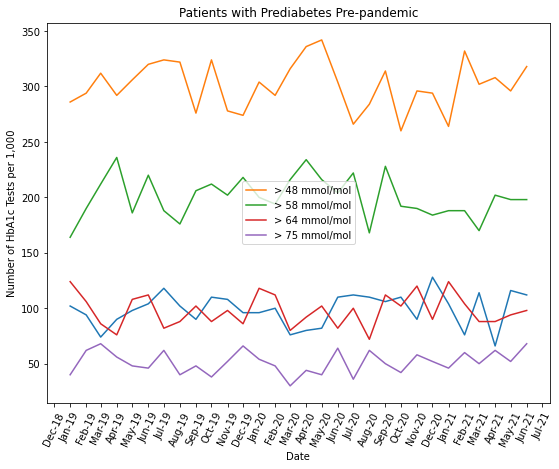

In [37]:
dict_col_rename = {'tests_per_1000':'Total','gt48_per_1000':'> 48 mmol/mol',
                   'gt58_per_1000':'> 58 mmol/mol','gt64_per_1000':'> 64 mmol/mol',
                   'gt75_per_1000':'> 75 mmol/mol'}

plt_cols = ['Total','> 48 mmol/mol','> 58 mmol/mol','> 64 mmol/mol','> 75 mmol/mol']

fig, ax = plt.subplots(figsize=(9, 7))
create_chart('Patients with Prediabetes Pre-pandemic', 
             df_predm.rename(columns=dict_col_rename), plt_cols, ax)

### By Demographics

In [38]:
# List of value change dfs
li_df_predm = [df_predm_age, df_predm_sex, df_predm_eth, 
               df_predm_reg, df_predm_imd, df_predm_ld, df_predm_mi]

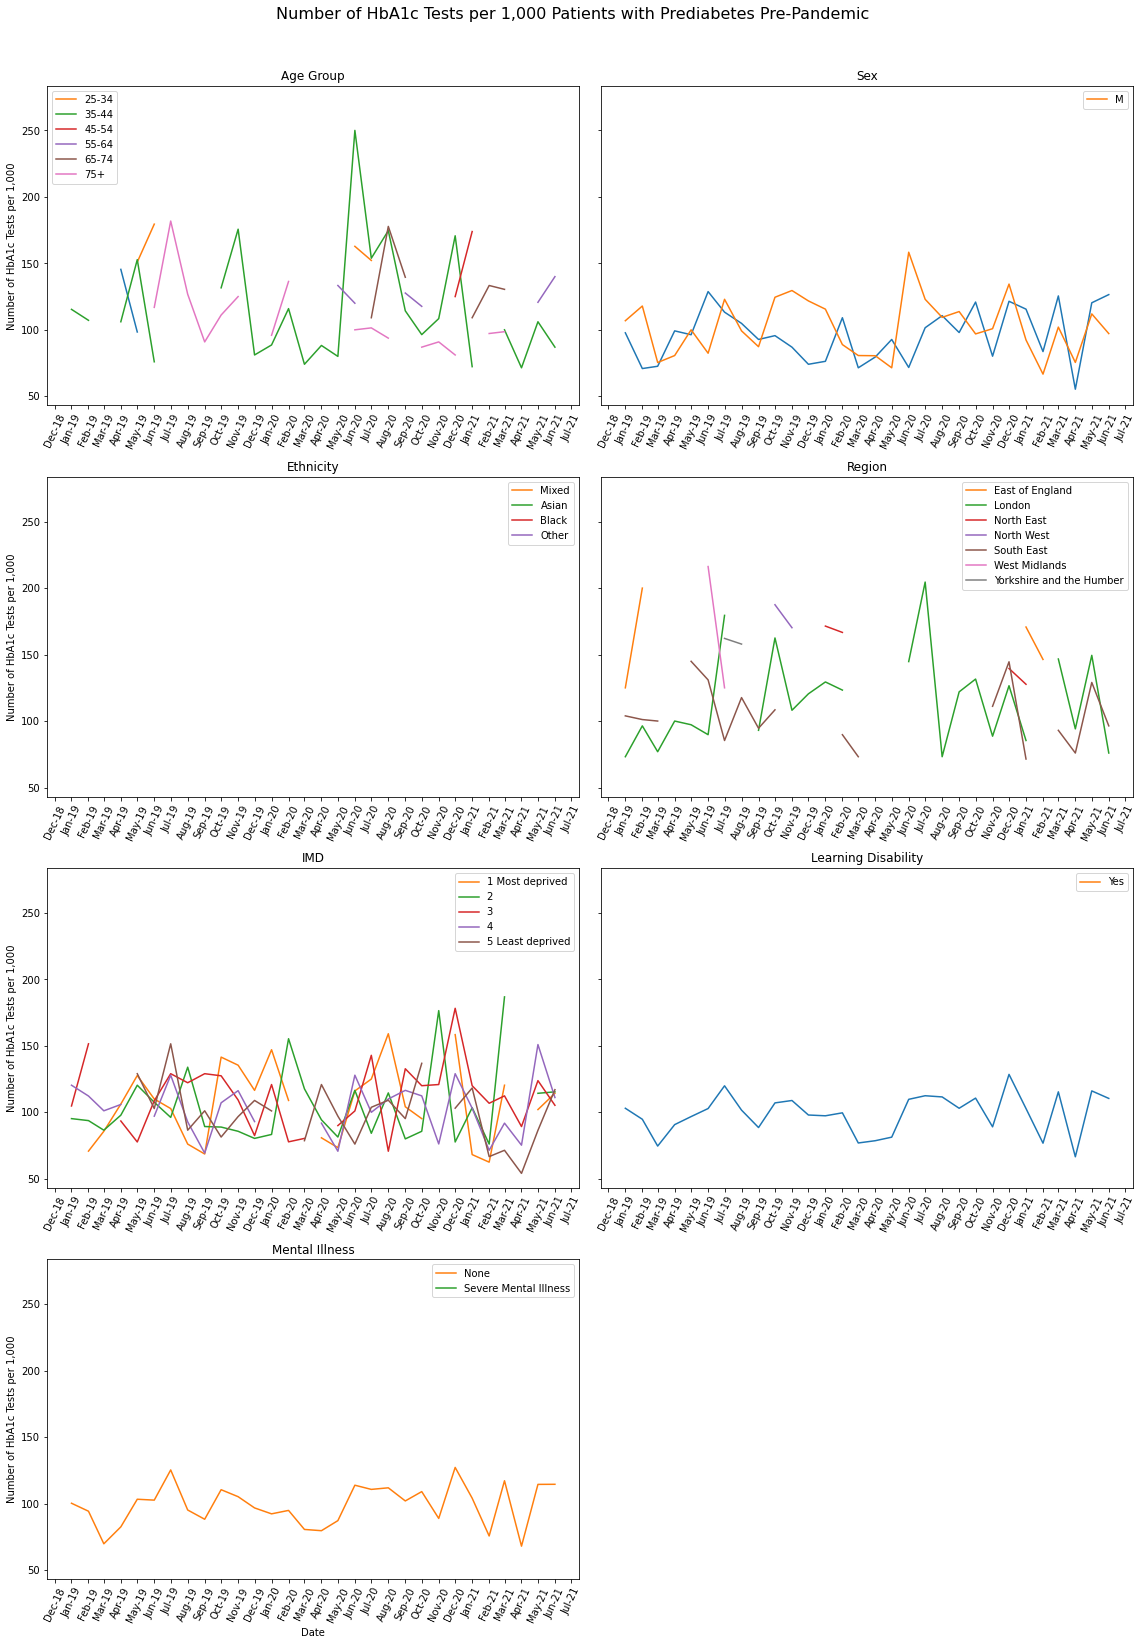

In [39]:
# Total tests
create_plotgrid('tests_per_1000', li_df_predm, 'Number of HbA1c Tests per 1,000', 'predm_total',
                'Number of HbA1c Tests per 1,000 Patients with Prediabetes Pre-Pandemic')

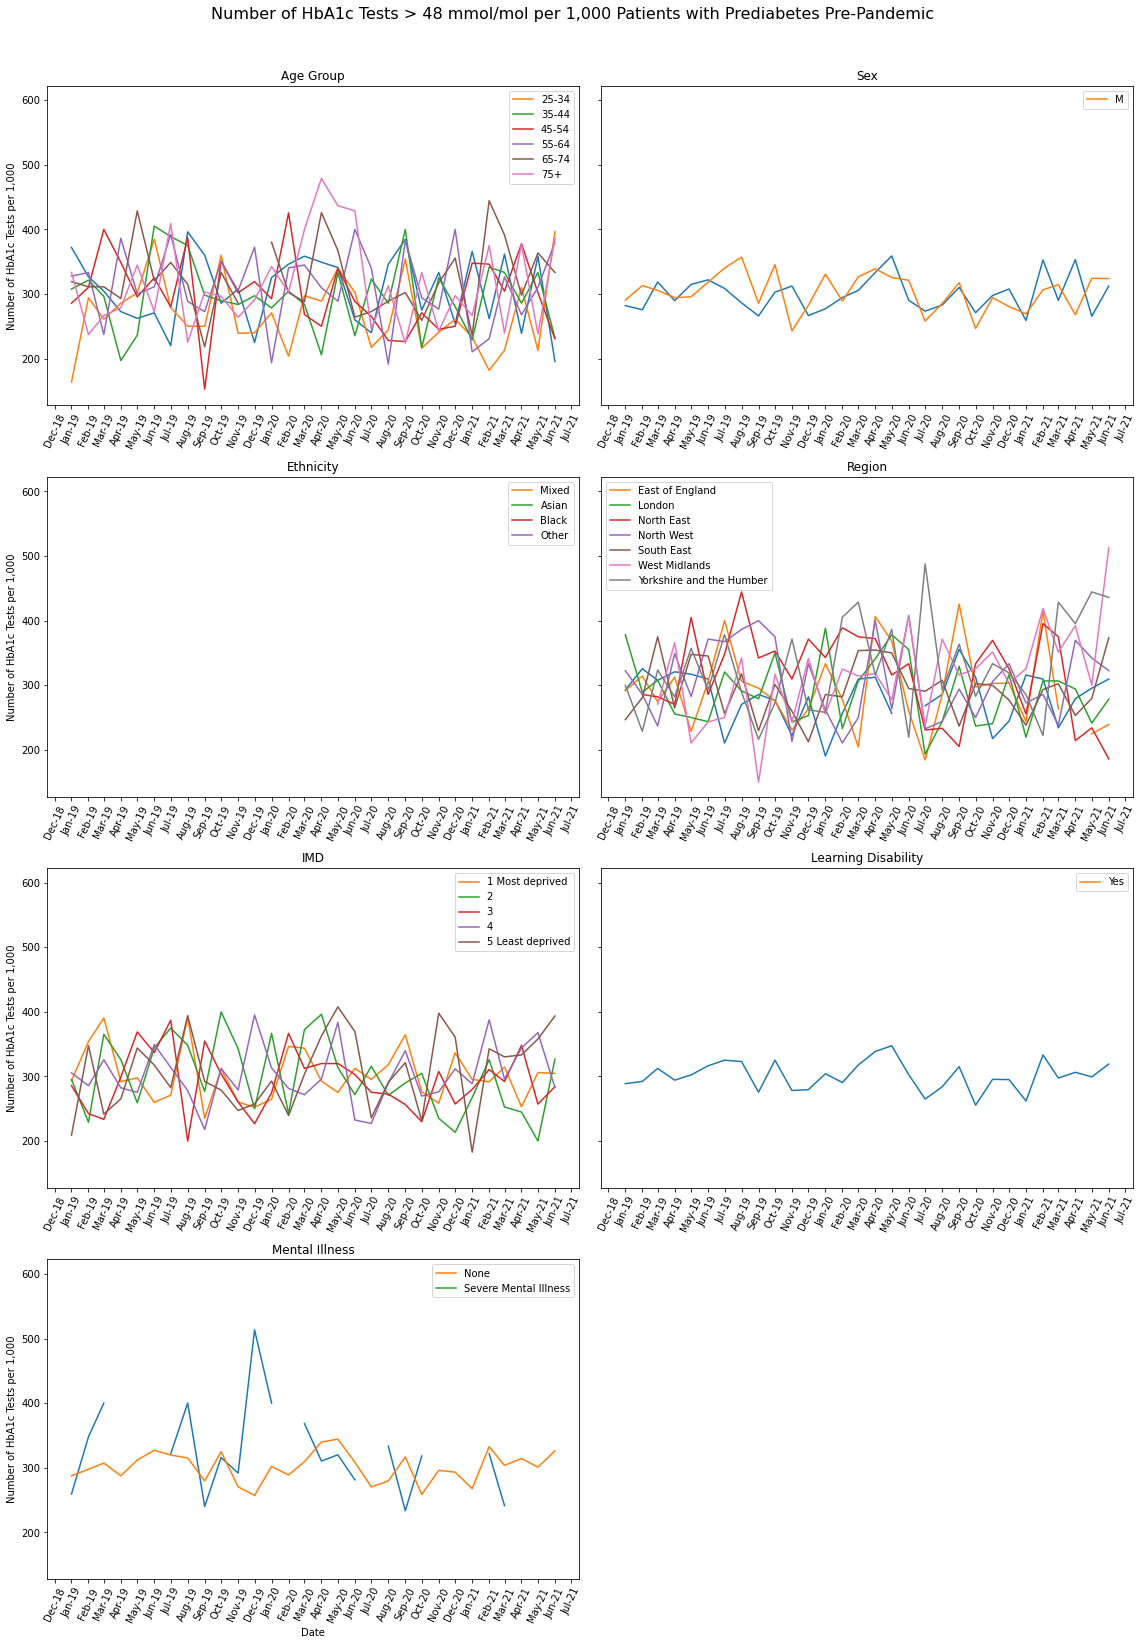

In [40]:
# 48 mmol/mol
create_plotgrid('gt48_per_1000', li_df_predm, 'Number of HbA1c Tests per 1,000','predm_gt_48',
                'Number of HbA1c Tests > 48 mmol/mol per 1,000 Patients with Prediabetes Pre-Pandemic')

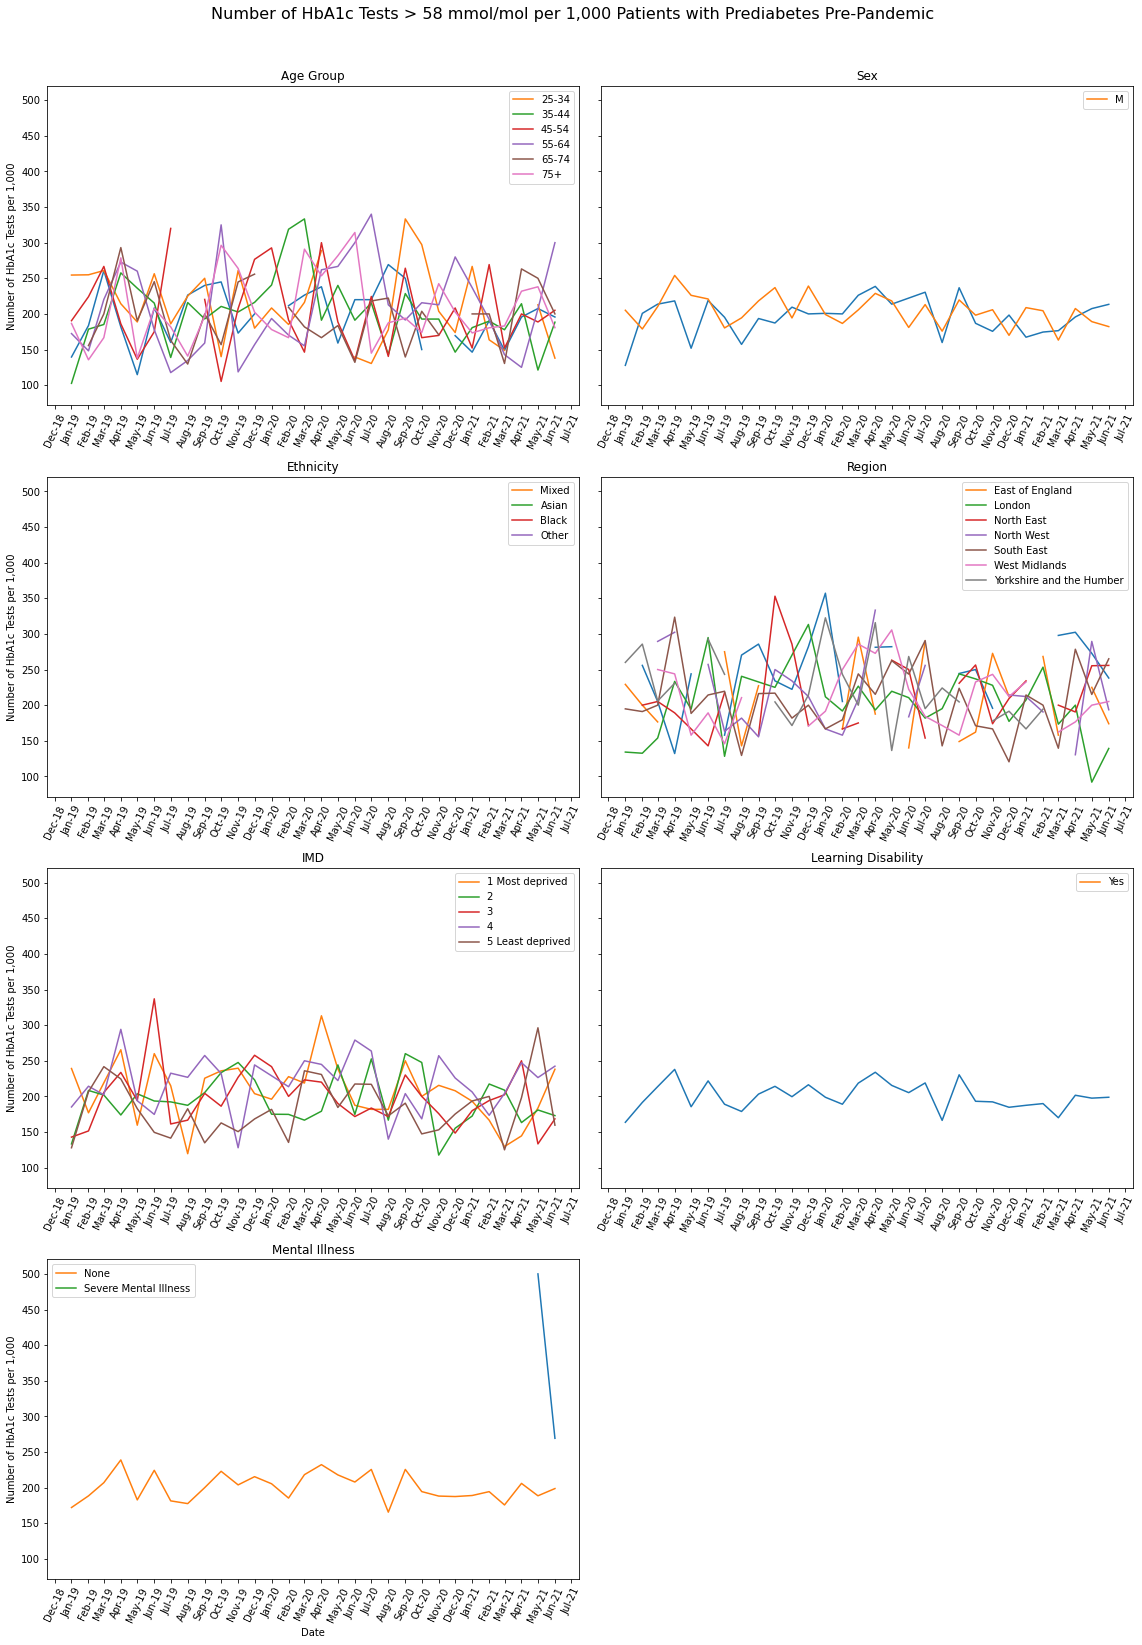

In [41]:
# 58 mmol/mol
create_plotgrid('gt58_per_1000', li_df_predm, 'Number of HbA1c Tests per 1,000','predm_gt_58',
                'Number of HbA1c Tests > 58 mmol/mol per 1,000 Patients with Prediabetes Pre-Pandemic')

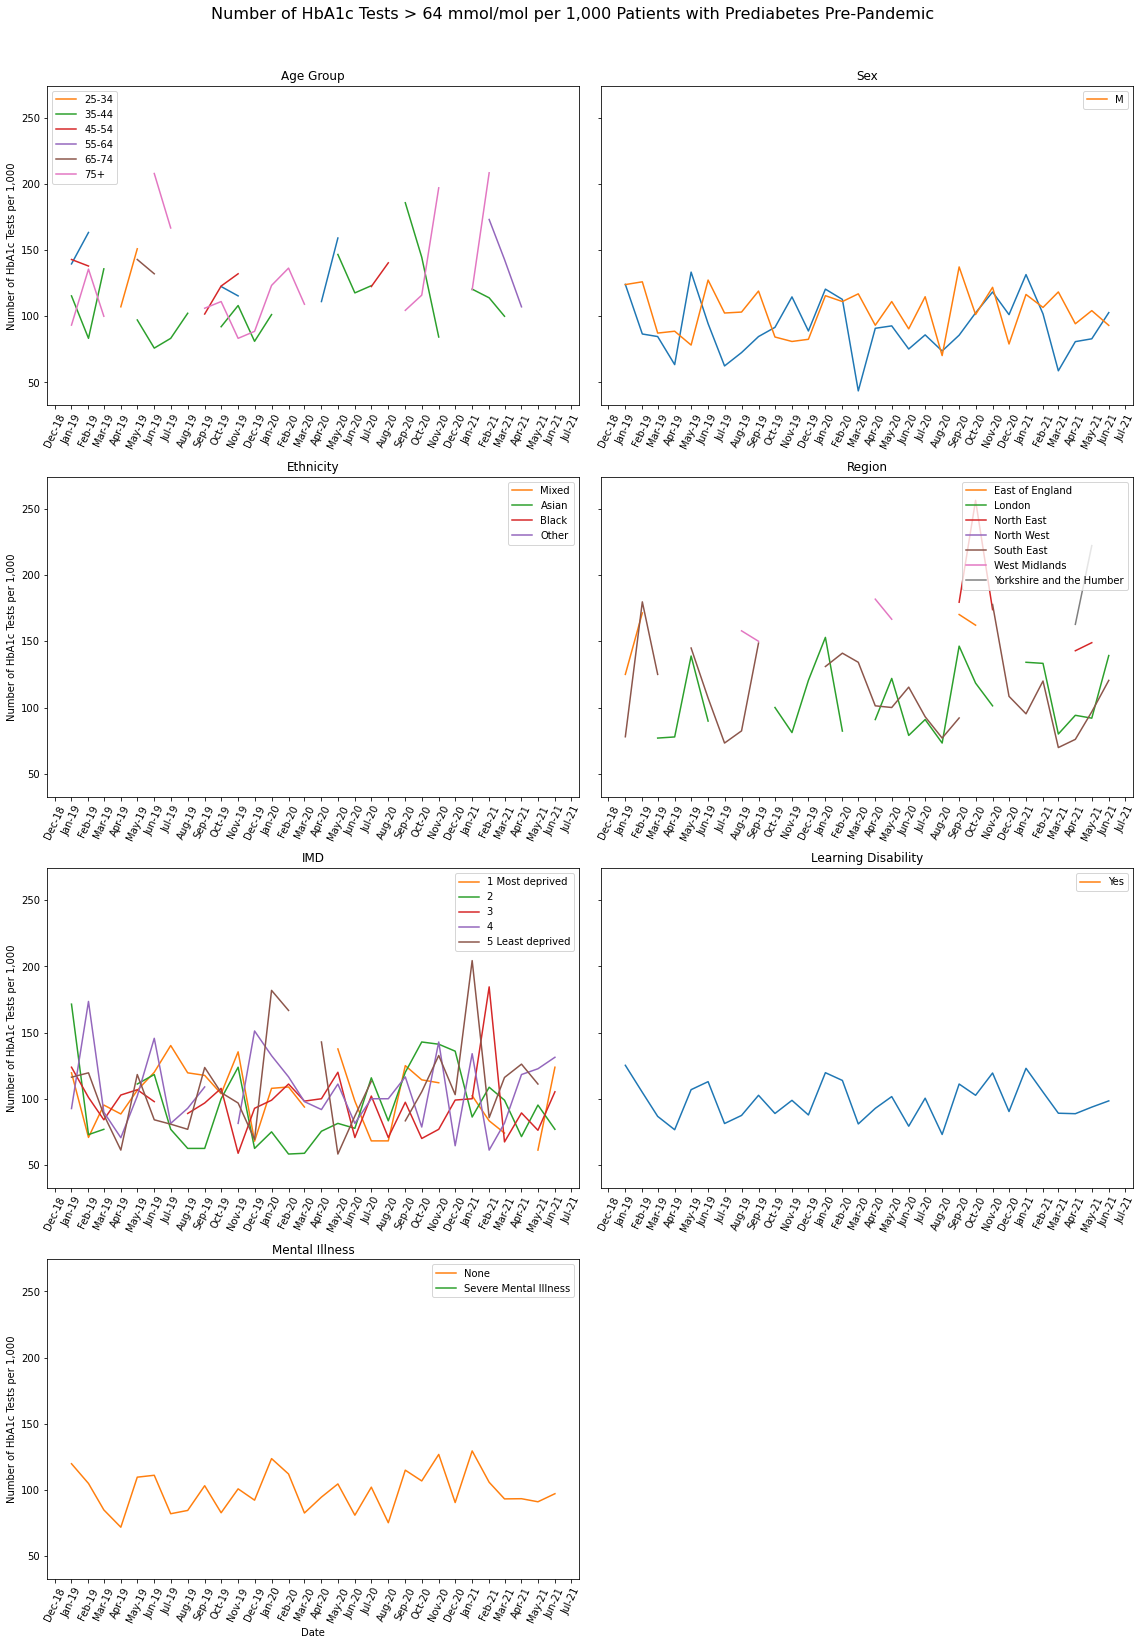

In [42]:
# 64 mmol/mol
create_plotgrid('gt64_per_1000', li_df_predm, 'Number of HbA1c Tests per 1,000','predm_gt_64',
                'Number of HbA1c Tests > 64 mmol/mol per 1,000 Patients with Prediabetes Pre-Pandemic')

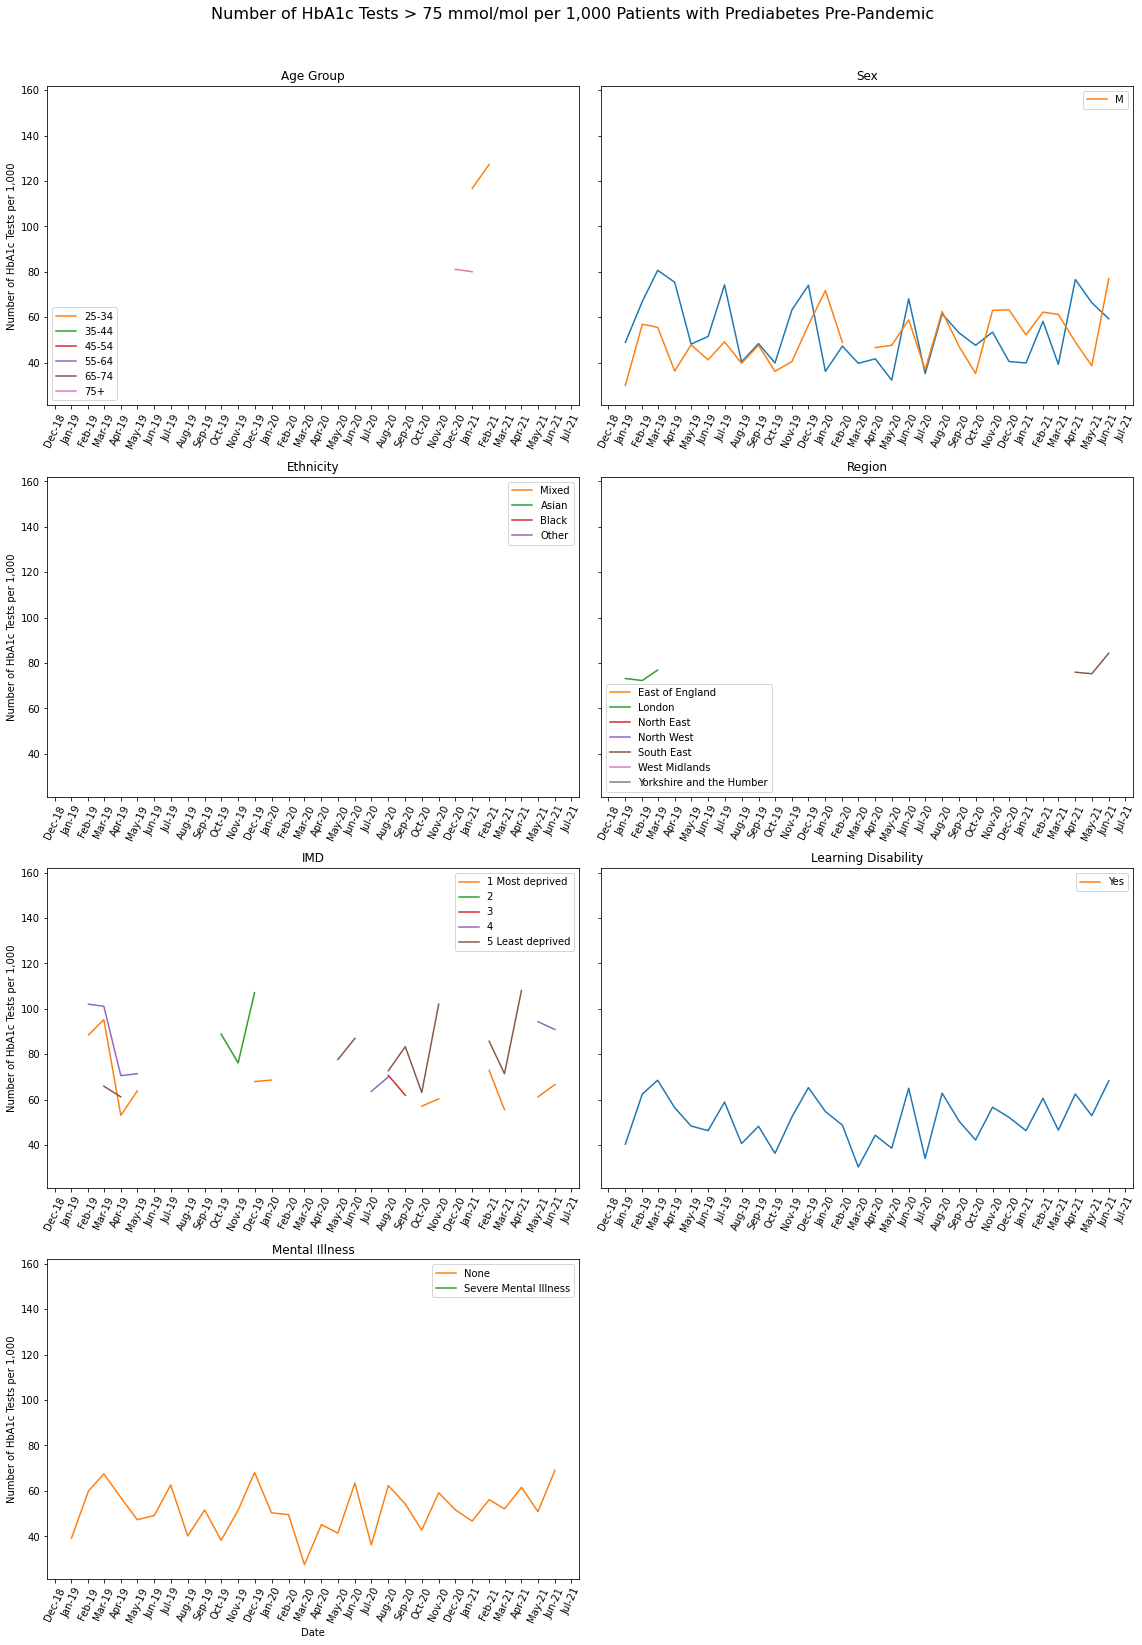

In [43]:
# 75 mmol/mol
create_plotgrid('gt75_per_1000', li_df_predm, 'Number of HbA1c Tests per 1,000','predm_gt_75',
                'Number of HbA1c Tests > 75 mmol/mol per 1,000 Patients with Prediabetes Pre-Pandemic')